In [1]:
""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import percephone.core.recording as pc
import percephone.plts.behavior as pbh
import percephone.plts.stats as ppt
import percephone.analysis.mlr_models as mlr_m
import numpy as np
import pandas as pd
import scipy.stats as ss
from multiprocessing import Pool, cpu_count, pool
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
fontsize = 20

In [2]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

In [3]:
def fraction_resp( pattern, n_type, ko, stim_ampl="all", no_go_normalize=True):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        no_go_filter = rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_no_go = resp_mat[:, no_go_filter]
        trials_detected = resp_mat[:, ampl_det_filt]
        trials_undetected = resp_mat[:, ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
            trials_no_go[trials_no_go!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0
            trials_no_go[trials_no_go!=pattern]=0
        
        # The total number of neurons is computed
        total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
        
        # Computation of the number of responsive neurons
        recruited_det = np.mean(np.count_nonzero(trials_detected,axis=0))
        recruited_undet = np.mean(np.count_nonzero(trials_undetected,axis=0))
        
        # Normalization b the number of responsive neurons for no-go trials
        if no_go_normalize:
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go,axis=0))
            recruited_det -= recruited_no_go
            recruited_undet -= recruited_no_go
            recruited_det = 0 if recruited_det < 0 else recruited_det
            recruited_undet = 0 if recruited_undet < 0 else recruited_undet
        
        # Computation of the percentage of responsive neurons
        perc_n_det = (recruited_det/total_n)*100
        perc_n_undet = (recruited_undet/total_n)*100
        
        # Storing the computed percentage in the corresponding list
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    return wt_det, ko_det, wt_undet, ko_undet

In [4]:
def plot_neuron_frac_wt_ko(pattern, ko, stim_ampl="all", ylim=[], no_go_normalize=True):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type="EXC", ko=ko, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    ppt.boxplot(axs[0, 0], wt_det,ko_det,"Neurons(%)",ylim=ylim)
    axs[0, 0].set_title("EXC Detected", fontsize=10)
    ppt.boxplot(axs[0, 1], wt_undet,ko_undet,"Neurons(%)",ylim=ylim)
    axs[0, 1].set_title("EXC Undetected", fontsize=10)
    
    wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=pattern, n_type="INH", ko=ko, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
    ppt.boxplot(axs[1, 0], wt_det1,ko_det1,"Neurons(%)",ylim=ylim)
    axs[1, 0].set_title("INH Detected", fontsize=10)
    ppt.boxplot(axs[1, 1], wt_undet1,ko_undet1,"Neurons(%)",ylim=ylim)
    axs[1, 1].set_title("INH Undetected", fontsize=10)
    
    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Percentage of neurons {t_pattern} during stimulus detected and undetected (amplitude: {stim_ampl})", fontsize=fontsize)

# Comparison WT vs KO (including ko-Hypo)


## Fraction of neurons recruited (1 and -1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8636596042790659, pvalue=0.1050641205802007)
ShapiroResult(statistic=0.5382740308209298, pvalue=1.8023043083097792e-05)
MannwhitneyuResult(statistic=65.0, pvalue=0.029015337752117745)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.879578473263226, pvalue=0.15542433489272933)
ShapiroResult(statistic=0.6031761503359409, pvalue=0.00010425136950542837)
MannwhitneyuResult(statistic=58.0, pvalue=0.1162378565206955)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5726420104254683, pvalue=4.566864266367205e-05)
ShapiroResult(statistic=0.8217578275391603, pvalue=0.03606915635991511)
MannwhitneyuResult(statistic=55.0, pvalue=0.2115959755844643)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5882815800861069, pvalue=6.970406862703592e-05)
ShapiroResult(statistic=0.7700093217125994, pvalue=0.009239321485202666)
MannwhitneyuResult(statistic=40.5, pvalue=1.0)
Boxplot plotting.
--- Neurons(%)

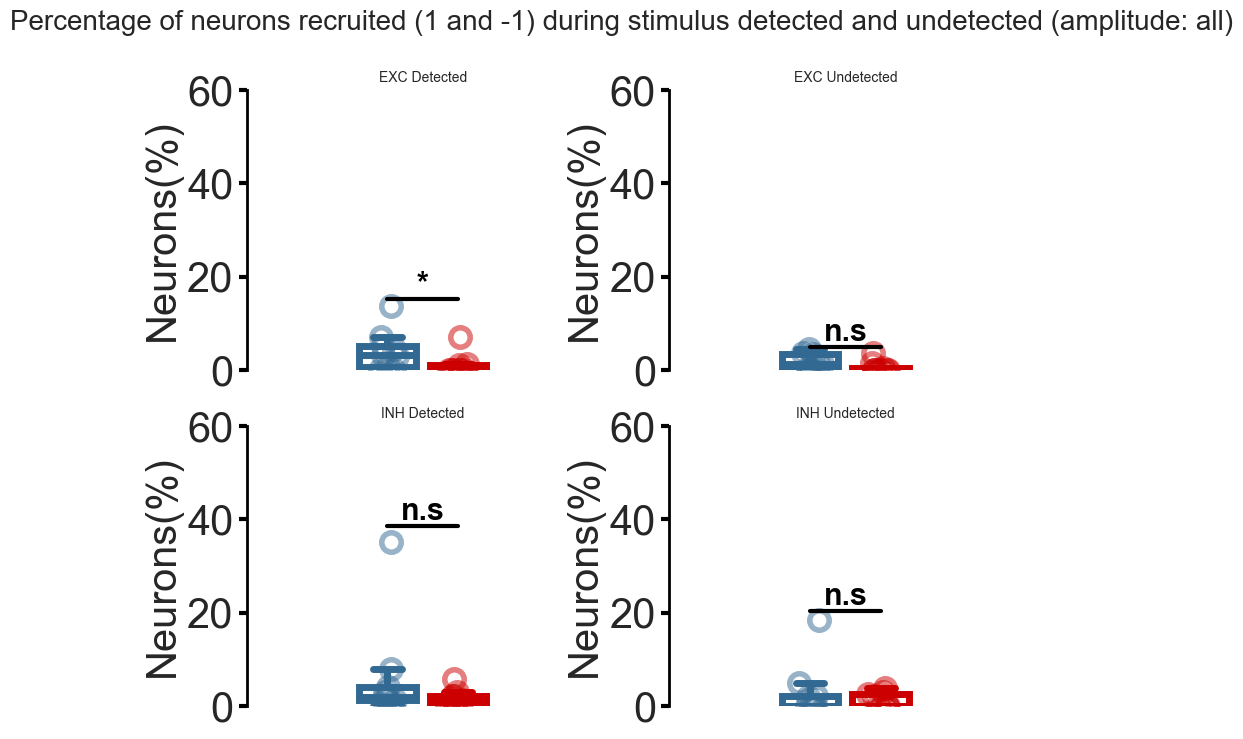

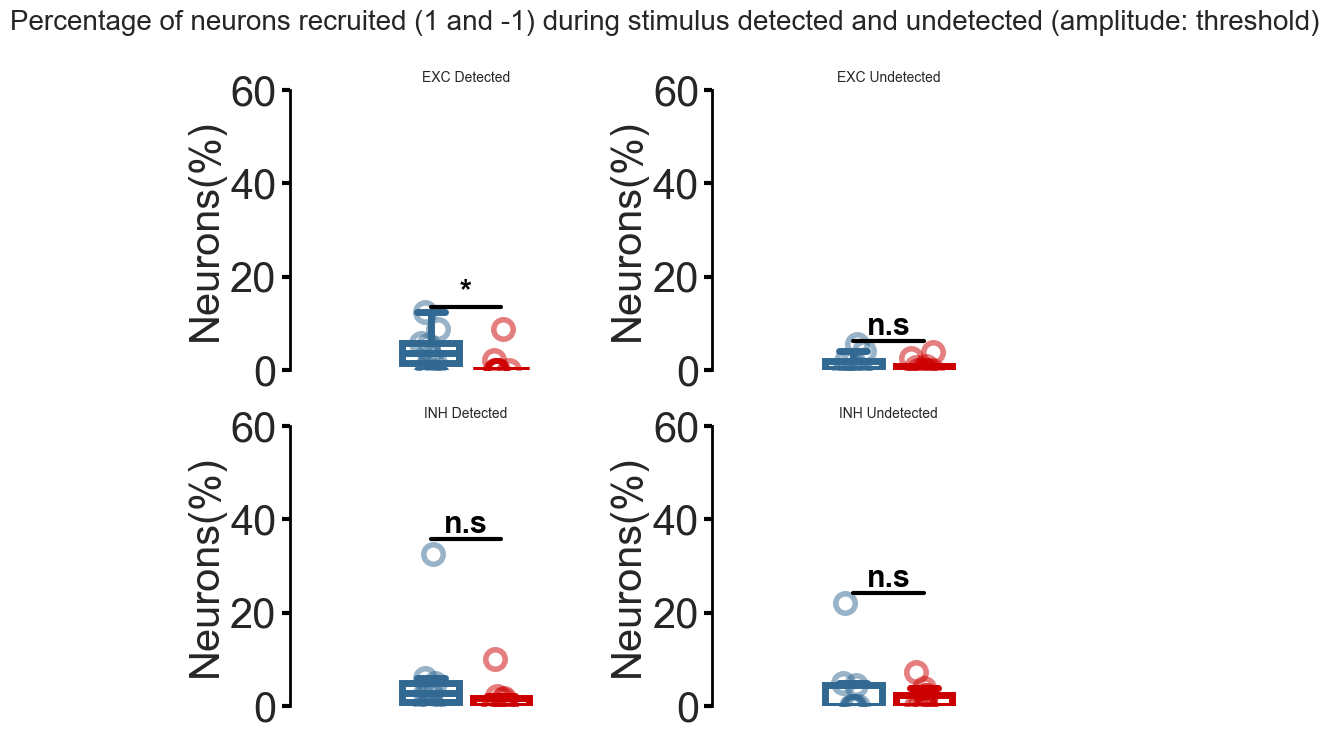

In [5]:
plot_neuron_frac_wt_ko(pattern=0, ko="KO", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko="KO", stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons activated (1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9012974689518968, pvalue=0.25961360616511475)
ShapiroResult(statistic=0.5260610047660592, pvalue=1.2949666851242633e-05)
MannwhitneyuResult(statistic=62.0, pvalue=0.05233674218142339)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8579963536742773, pvalue=0.09118484607524704)
ShapiroResult(statistic=0.5842188612201911, pvalue=6.245403430187422e-05)
MannwhitneyuResult(statistic=59.0, pvalue=0.09628038151495182)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7430729904125217, pvalue=0.00450561804886148)
ShapiroResult(statistic=0.7092892395435669, pvalue=0.0018217121710727621)
MannwhitneyuResult(statistic=55.0, pvalue=0.20796534244292952)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6503203948624401, pvalue=0.00037230049879015994)
ShapiroResult(statistic=0.7851101858217773, pvalue=0.013788868981255248)
MannwhitneyuResult(statistic=45.0, pvalue=0.7059167514776262)
Boxplot plotti

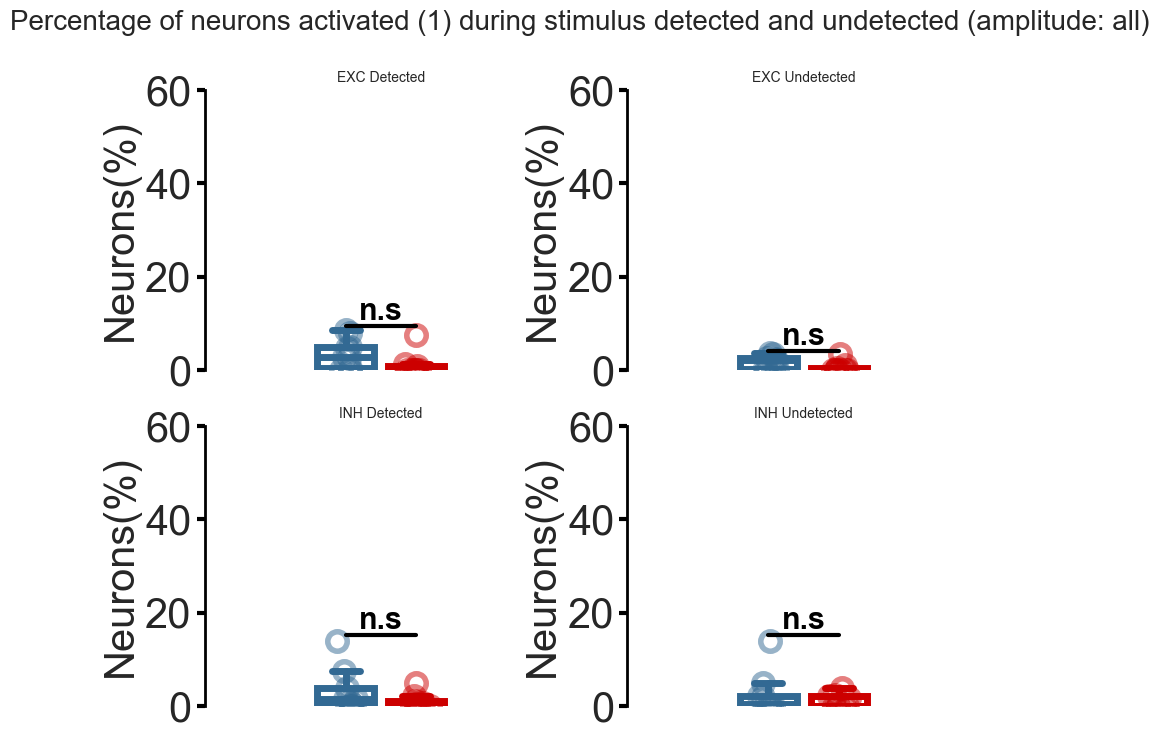

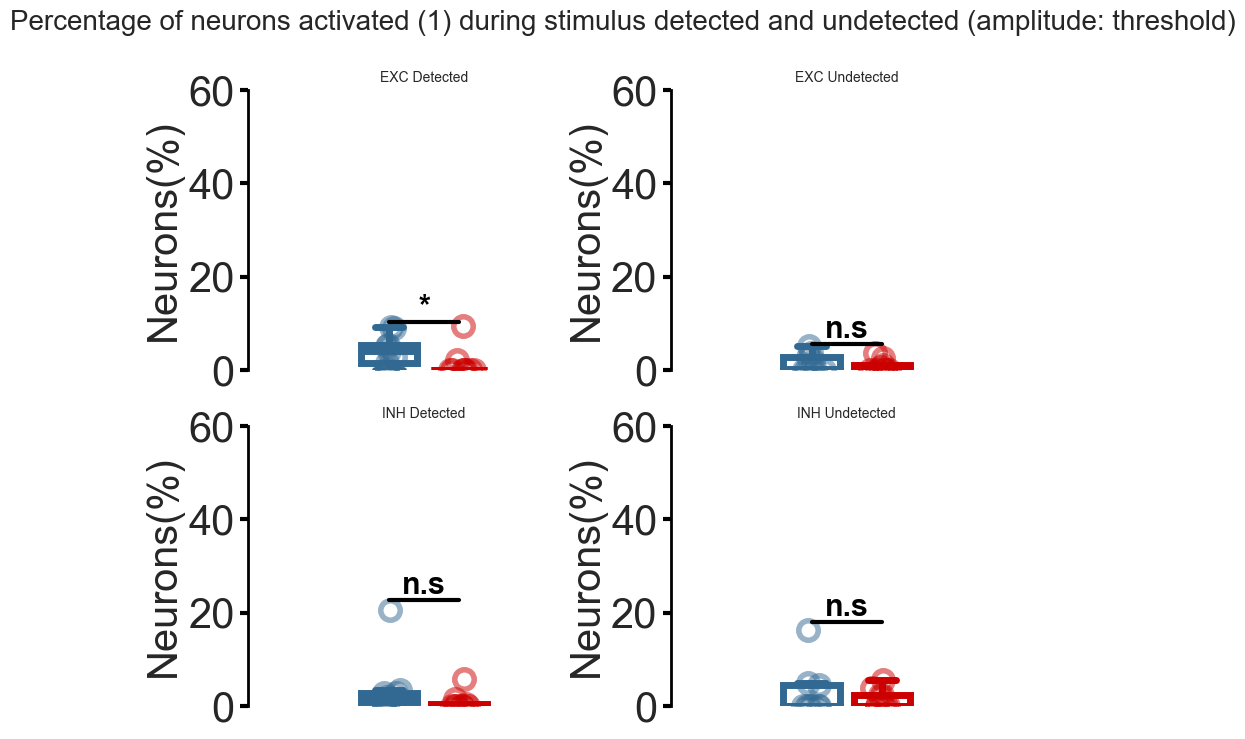

In [6]:
plot_neuron_frac_wt_ko(pattern=1, ko="KO", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko="KO", stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5099572247407815, pvalue=8.373106612716098e-06)
ShapiroResult(statistic=0.7246558310002903, pvalue=0.0027516194185861135)
MannwhitneyuResult(statistic=64.0, pvalue=0.03641095819976487)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8301099269928381, pvalue=0.04478173354653412)
ShapiroResult(statistic=0.8893561554790166, pvalue=0.19650702446163376)
MannwhitneyuResult(statistic=42.0, pvalue=0.9289008869362791)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.4513623519346477, pvalue=1.7105988109789248e-06)
ShapiroResult(statistic=0.7904265244613635, pvalue=0.015868566521367606)
MannwhitneyuResult(statistic=55.0, pvalue=0.2115959755844643)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.3898412978727055, pvalue=3.2174928627621727e-07)
ShapiroResult(statistic=0.8218139090221042, pvalue=0.03612174671980952)
MannwhitneyuResult(statistic=25.0, pvalue=0.11464316058022986)
Boxplot plottin

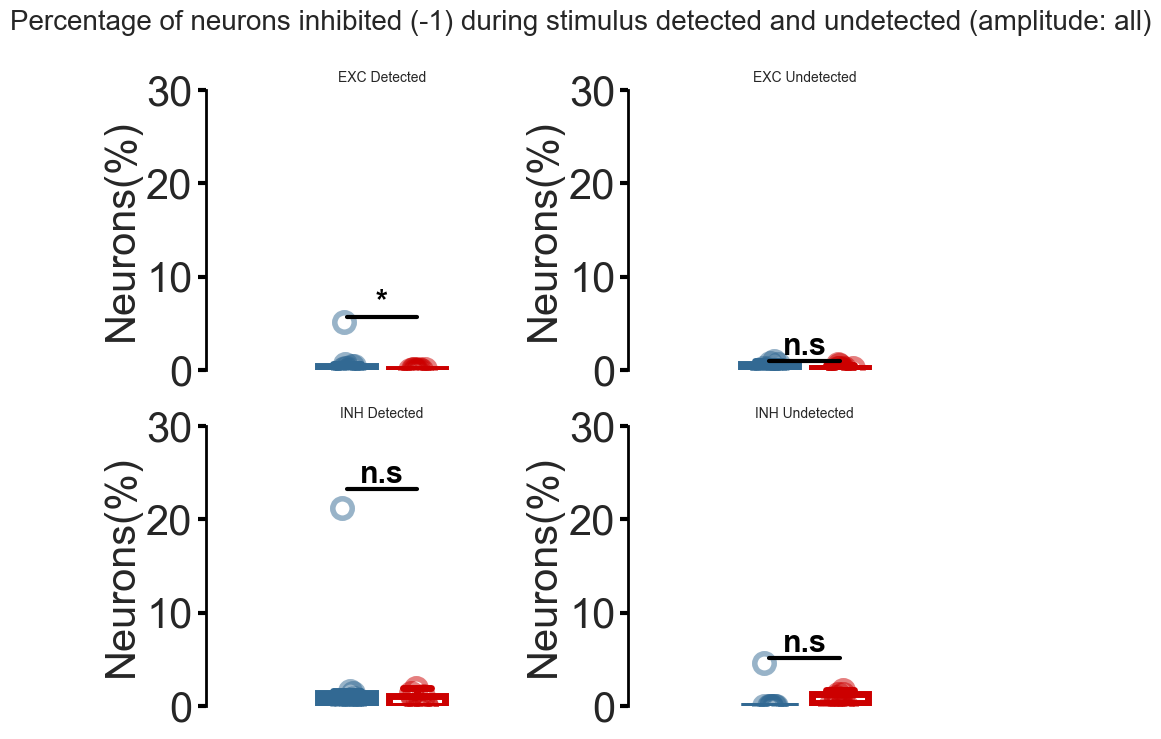

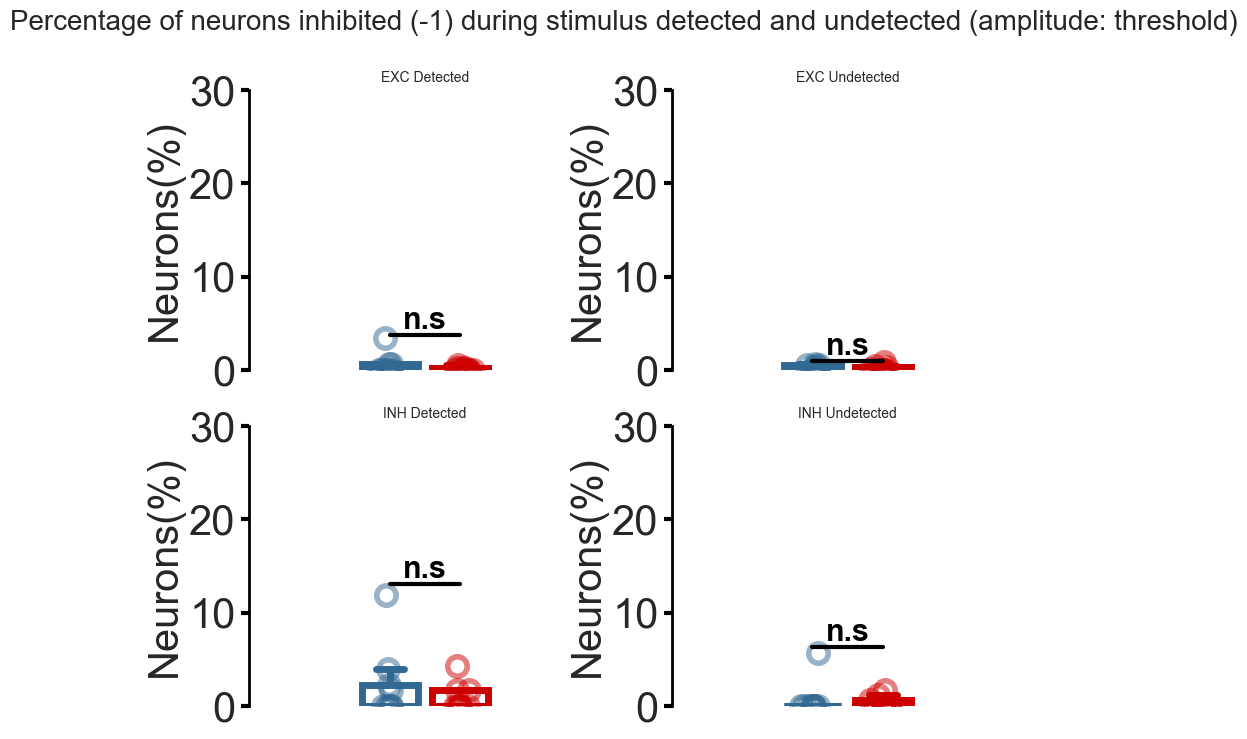

In [7]:
plot_neuron_frac_wt_ko(pattern=-1, ko="KO", stim_ampl="all", ylim=[0, 30])
plot_neuron_frac_wt_ko(pattern=-1, ko="KO", stim_ampl="threshold", ylim=[0, 30])

# Comparison WT vs Ko-Hypo

## Fraction of neurons recruited ( 1 and -1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8636596042790659, pvalue=0.1050641205802007)
ShapiroResult(statistic=0.6141069380517348, pvalue=0.0003980681721106978)
MannwhitneyuResult(statistic=48.0, pvalue=0.08559816927619072)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.879578473263226, pvalue=0.15542433489272933)
ShapiroResult(statistic=0.6893448168746794, pvalue=0.002833039287436972)
MannwhitneyuResult(statistic=42.0, pvalue=0.2771021364126126)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5726420104254683, pvalue=4.566864266367205e-05)
ShapiroResult(statistic=0.8988046701540842, pvalue=0.3238044111033446)
MannwhitneyuResult(statistic=38.0, pvalue=0.5241355305426594)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5882815800861069, pvalue=6.970406862703592e-05)
ShapiroResult(statistic=0.8390234879591373, pvalue=0.09729568476562821)
MannwhitneyuResult(statistic=27.5, pvalue=0.6923067201829018)
Boxplot plotting.
--- N

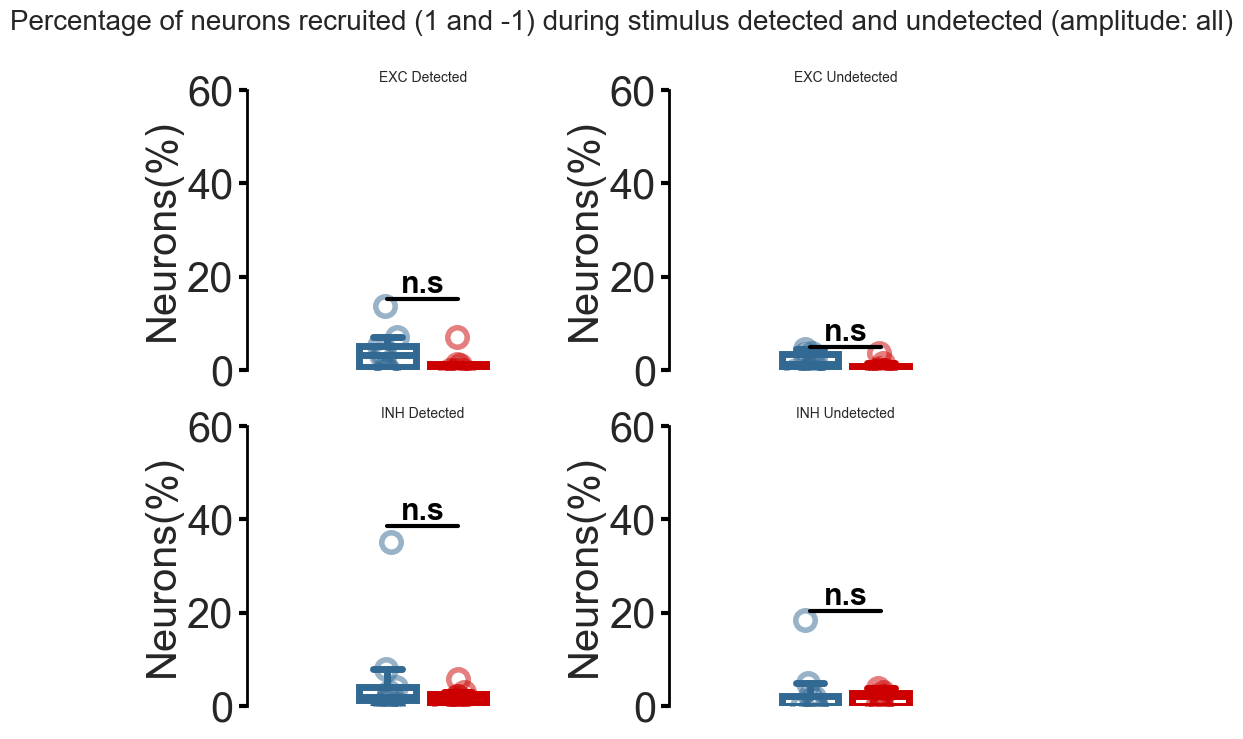

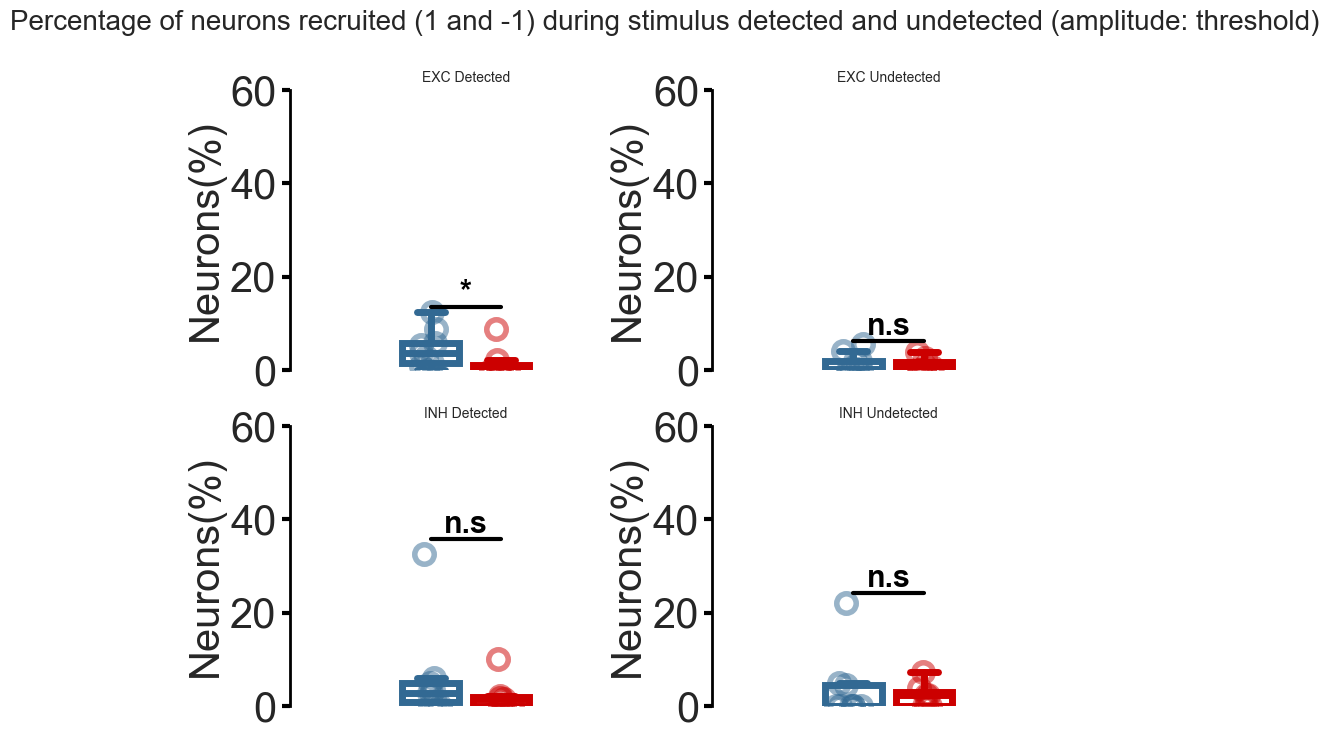

In [8]:
plot_neuron_frac_wt_ko(pattern=0, ko="KO-Hypo", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko="KO-Hypo", stim_ampl="threshold", ylim=[0, 60])
# from matplotlib.ticker import MaxNLocator
# axs[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
# axs[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))

## Fraction of neurons activated (1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9012974689518968, pvalue=0.25961360616511475)
ShapiroResult(statistic=0.6013049141618023, pvalue=0.0002820061798576861)
MannwhitneyuResult(statistic=46.0, pvalue=0.12811107444286923)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8579963536742773, pvalue=0.09118484607524704)
ShapiroResult(statistic=0.6681406789456539, pvalue=0.001647677864366729)
MannwhitneyuResult(statistic=43.0, pvalue=0.23187712746828482)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7430729904125217, pvalue=0.00450561804886148)
ShapiroResult(statistic=0.7892127514235512, pvalue=0.031987317013953874)
MannwhitneyuResult(statistic=39.0, pvalue=0.4553849754675213)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6503203948624401, pvalue=0.00037230049879015994)
ShapiroResult(statistic=0.8664819405256665, pvalue=0.1728753077663281)
MannwhitneyuResult(statistic=31.0, pvalue=1.0)
Boxplot plotting.
--- Neurons(%) --

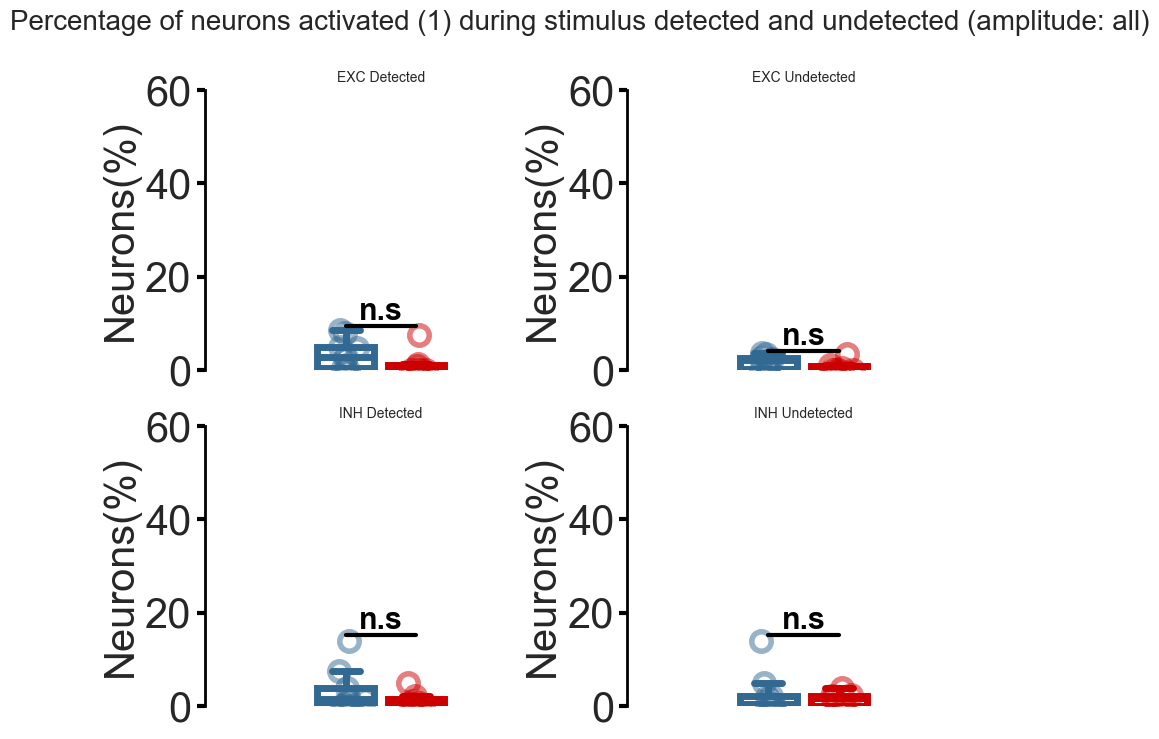

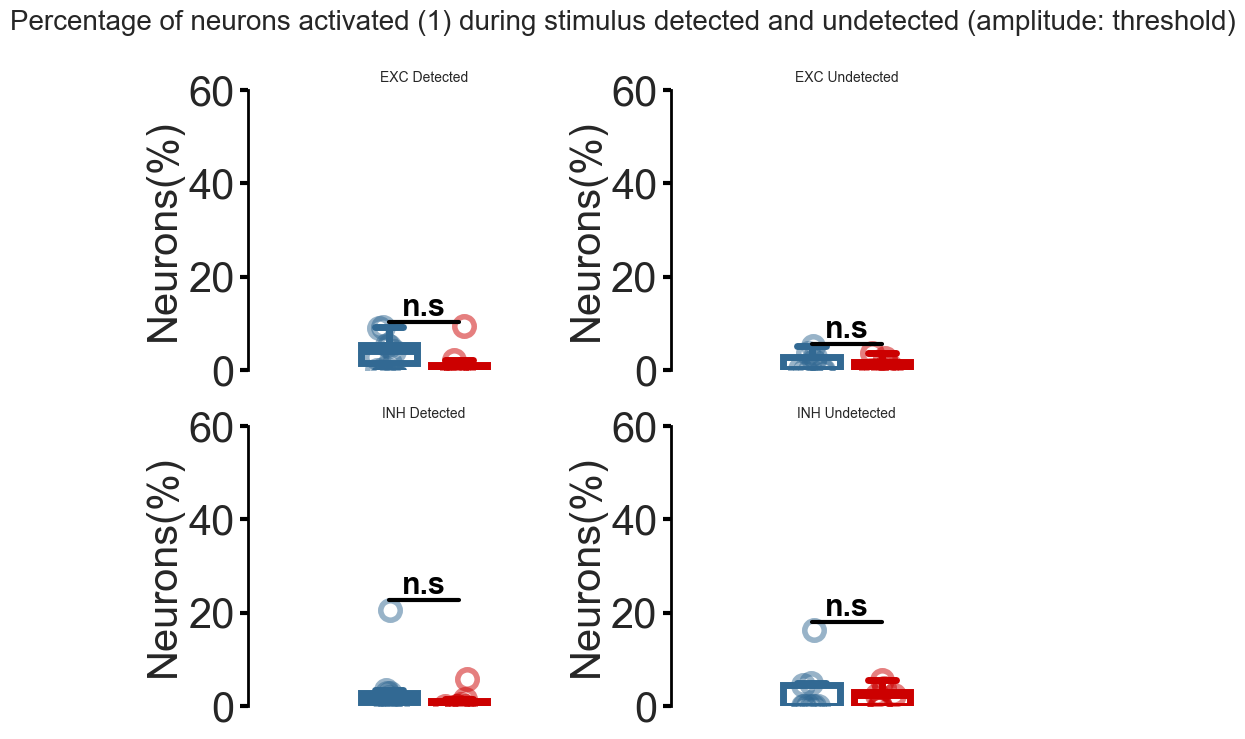

In [9]:
plot_neuron_frac_wt_ko(pattern=1, ko="KO-Hypo", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko="KO-Hypo", stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5099572247407815, pvalue=8.373106612716098e-06)
ShapiroResult(statistic=0.7271825951321498, pvalue=0.007285342618685573)
MannwhitneyuResult(statistic=50.0, pvalue=0.05042582730921761)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8301099269928381, pvalue=0.04478173354653412)
ShapiroResult(statistic=0.892421710486184, pvalue=0.28753554654850405)
MannwhitneyuResult(statistic=35.0, pvalue=0.747203325100659)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.4513623519346477, pvalue=1.7105988109789248e-06)
ShapiroResult(statistic=0.8766371680435252, pvalue=0.21193487224459617)
MannwhitneyuResult(statistic=37.0, pvalue=0.5955437542311808)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.3898412978727055, pvalue=3.2174928627621727e-07)
ShapiroResult(statistic=0.7053028305018543, pvalue=0.004234679579045571)
MannwhitneyuResult(statistic=23.0, pvalue=0.2659318158635411)
Boxplot plotting.
-

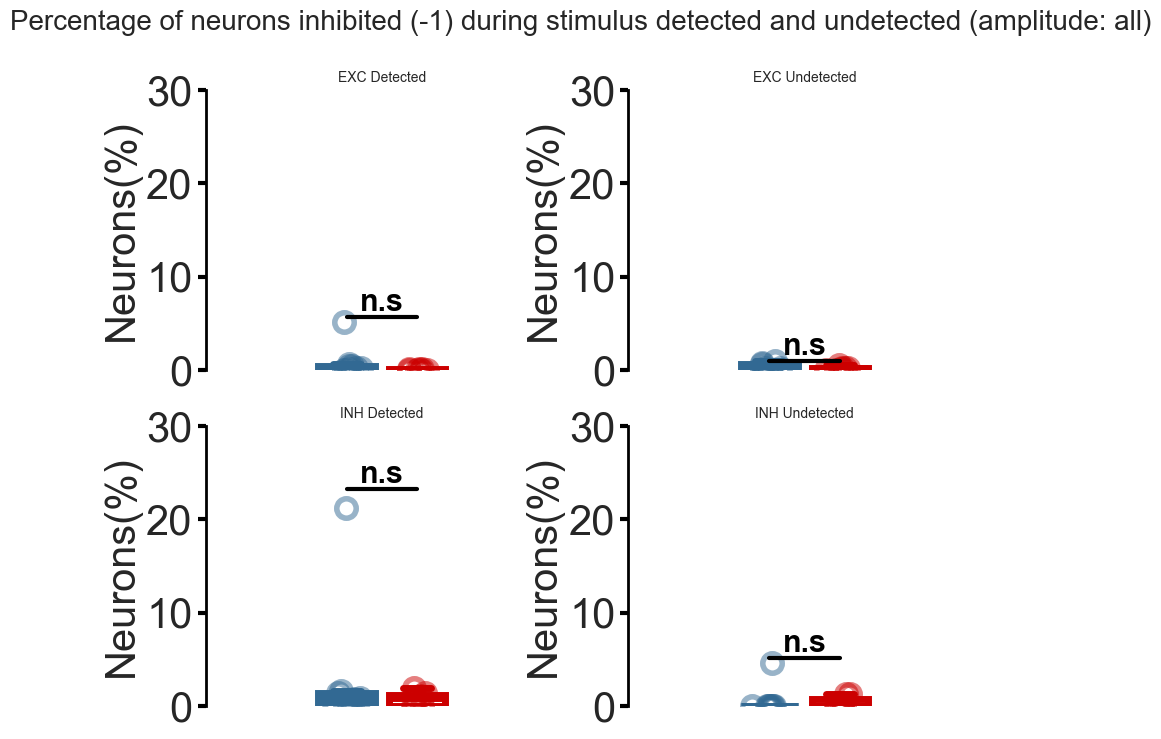

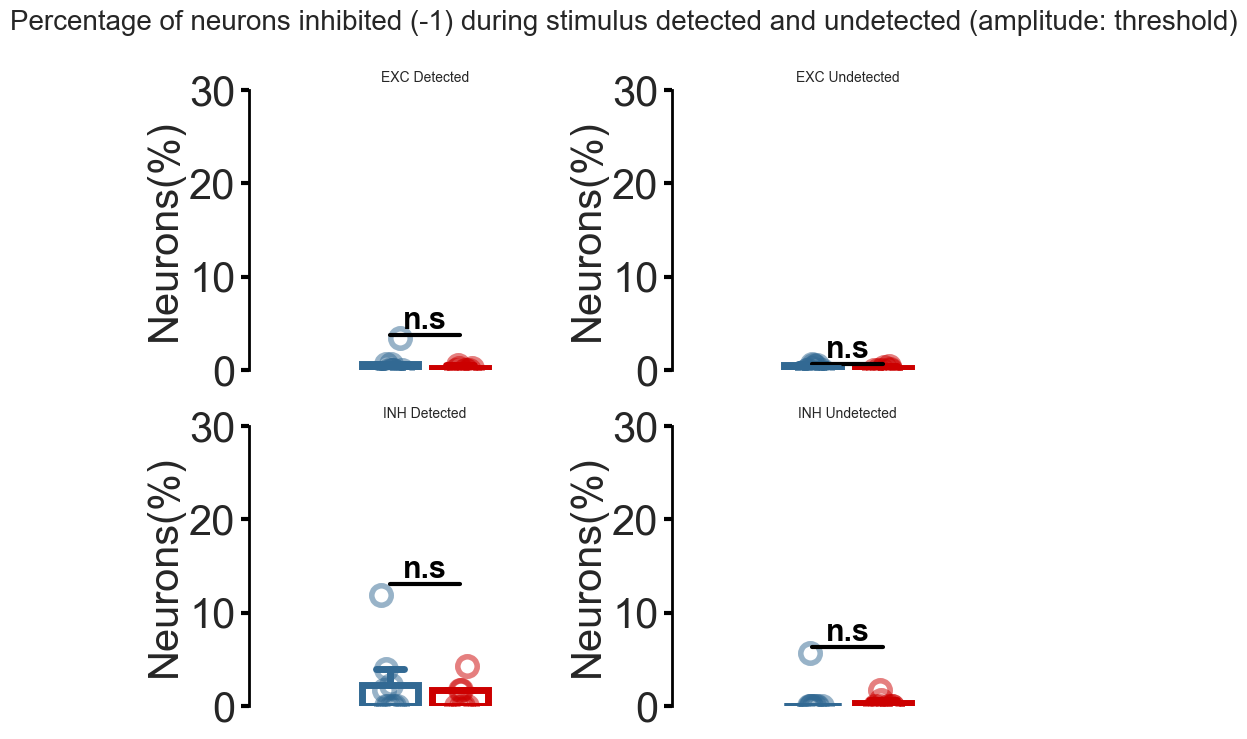

In [10]:
plot_neuron_frac_wt_ko(pattern=-1, ko="KO-Hypo", stim_ampl="all", ylim=[0, 30])
plot_neuron_frac_wt_ko(pattern=-1, ko="KO-Hypo", stim_ampl="threshold", ylim=[0, 30])

## Fraction of neurons activated (1) for stim amp of 6

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=nan, pvalue=nan)
ShapiroResult(statistic=nan, pvalue=nan)
MannwhitneyuResult(statistic=nan, pvalue=nan)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=nan, pvalue=nan)
ShapiroResult(statistic=0.6295206910695113, pvalue=0.0006003551123024775)
MannwhitneyuResult(statistic=nan, pvalue=nan)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=nan, pvalue=nan)
ShapiroResult(statistic=nan, pvalue=nan)
MannwhitneyuResult(statistic=nan, pvalue=nan)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=nan, pvalue=nan)
ShapiroResult(statistic=0.7845123395705231, pvalue=0.028690211085701387)
MannwhitneyuResult(statistic=nan, pvalue=nan)


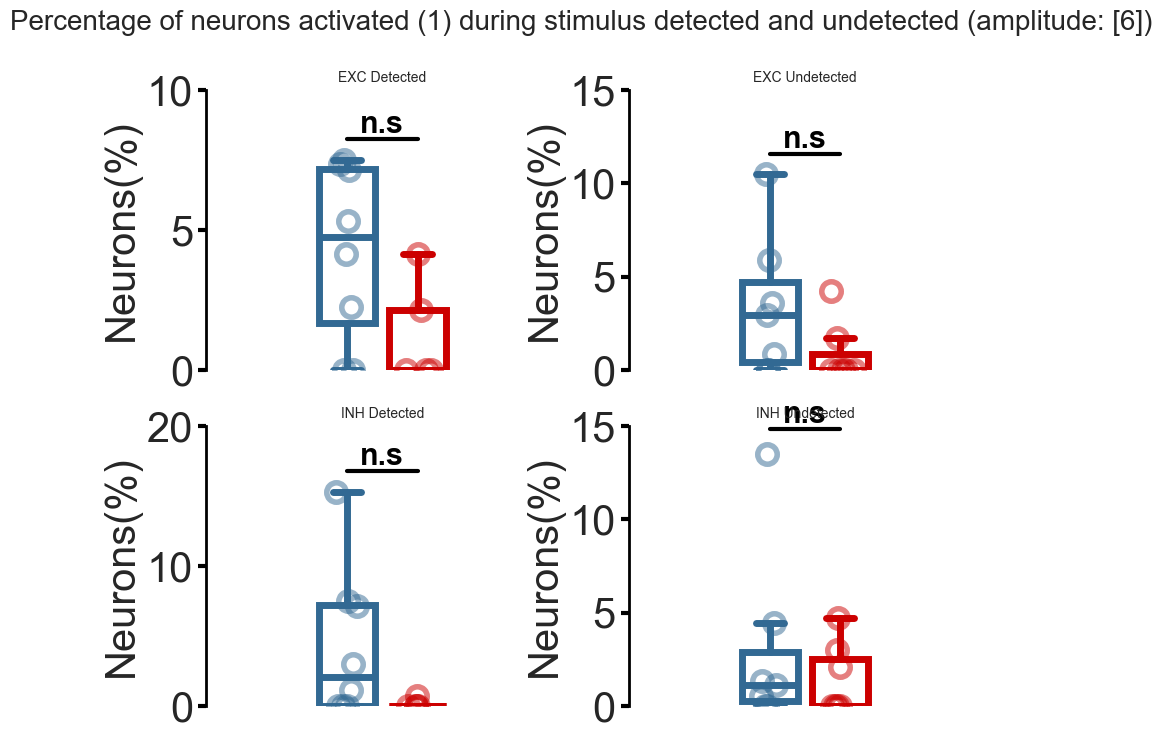

In [11]:
plot_neuron_frac_wt_ko(pattern=1, ko="KO-Hypo", stim_ampl=[6], ylim=[])
# fig, axs = plt.subplots(2,2,figsize=(10,14))
# 
# for i,type in enumerate(["EXC","INH"]):
#     wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
#     for rec in recs.values():
#         resp_mat = np.array(rec.matrices[type]["Responsivity"])
#         #detected
#         trials_detected = resp_mat[:,(rec.stim_ampl==6)]
#         trials_detected[trials_detected!=1]=0
#         recruited_det = np.sum(trials_detected,axis=0)
#         total_n = len(rec.zscore_exc)
#         if type== "INH":
#             total_n = len(rec.zscore_inh)
#         perc_n_det = (np.mean(recruited_det)/total_n)*100
#         #undetected
#         trials_undetected = resp_mat[:,(rec.stim_ampl==6)]
#         trials_undetected[trials_undetected!=1]=0
#         recruited_undet = np.sum(trials_undetected,axis=0)
#         perc_n_undet = (np.mean(recruited_undet)/total_n)*100
#         if rec.genotype == "WT":
#             wt_det.append(perc_n_det)
#             wt_undet.append(perc_n_undet)
#         elif rec.genotype =="KO-Hypo":
#             ko_det.append(perc_n_det)
#             ko_undet.append(perc_n_undet)
#     ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[0,20])
#     ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[0,20])
#     axs[i,0].yaxis.set_major_locator(MaxNLocator(integer=True))
#     axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))

# Comparison group det vs group undet


## Fraction of neurons recruited (1 and -1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8636596042790659, pvalue=0.1050641205802007)
ShapiroResult(statistic=0.879578473263226, pvalue=0.15542433489272933)
TtestResult(statistic=1.9118166151758875, pvalue=0.09227246837833213, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6141069380517348, pvalue=0.0003980681721106978)
ShapiroResult(statistic=0.6893448168746794, pvalue=0.002833039287436972)
WilcoxonResult(statistic=3.0, pvalue=0.4652088184521418)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5726420104254683, pvalue=4.566864266367205e-05)
ShapiroResult(statistic=0.5882815800861069, pvalue=6.970406862703592e-05)
WilcoxonResult(statistic=9.0, pvalue=0.12890625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8988046701540842, pvalue=0.3238044111033446)
ShapiroResult(statistic=0.8390234879591373, pvalue=0.09729568476562821)
TtestResult(statistic=0.376474925164986, pvalue=0.7195177438612408, df=6)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


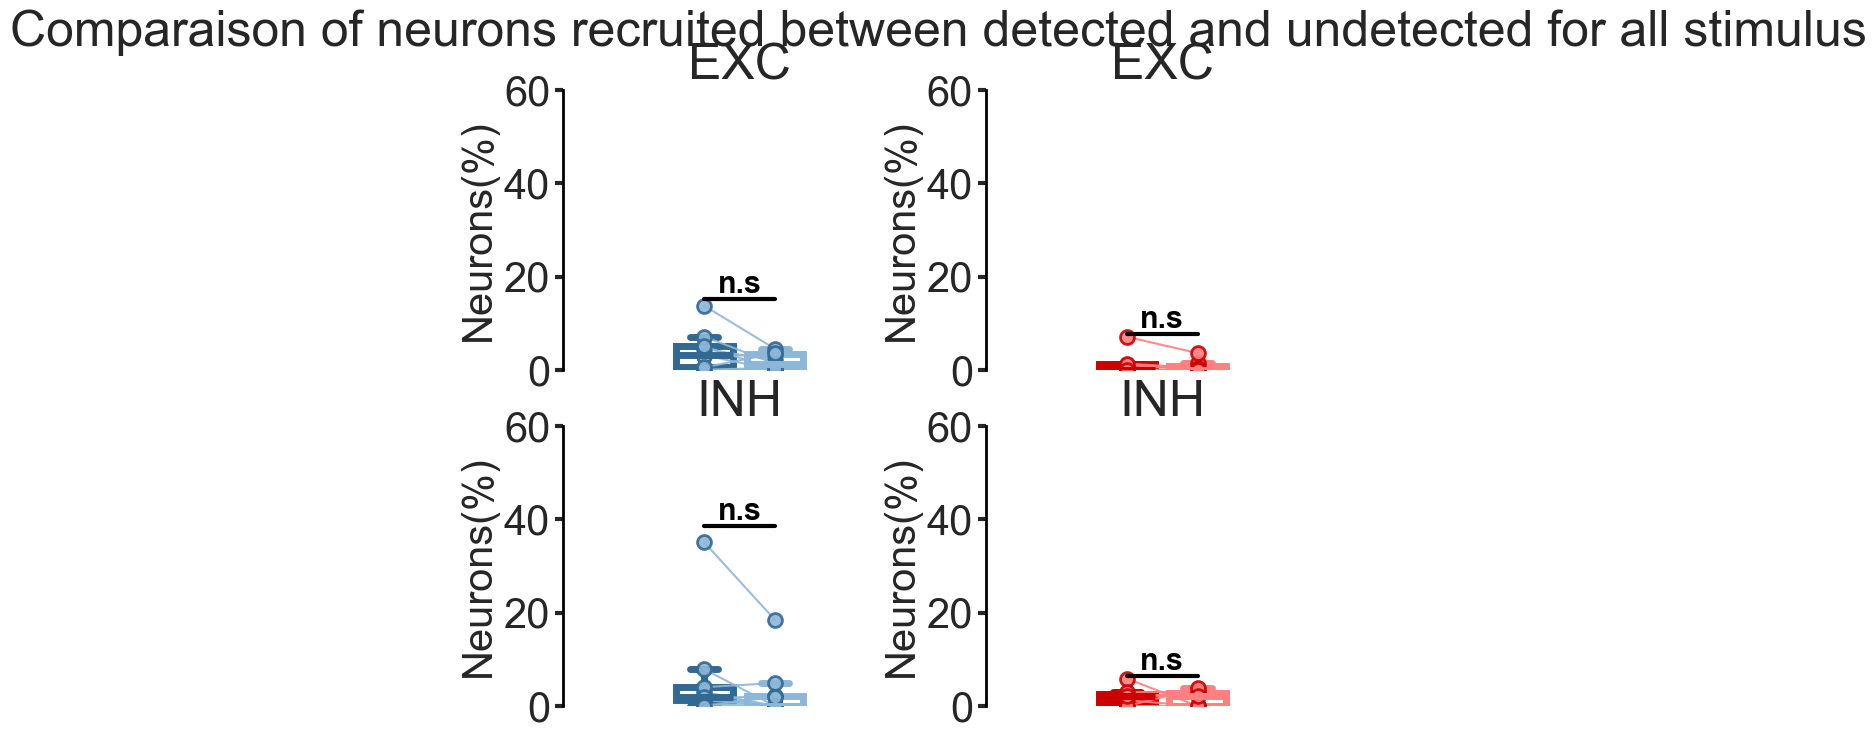

In [22]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=0, n_type=type, ko="KO-Hypo", stim_ampl="all")
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)", type,ylim=[0,50],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)", type,ylim=[0,50])
    fig.suptitle("Comparaison of neurons recruited between detected and undetected for all stimulus")

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9332669247370253, pvalue=0.5130608592646024)
ShapiroResult(statistic=0.7829669768064729, pvalue=0.013028688460585955)
WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5796051719189268, pvalue=0.00015611456901088106)
ShapiroResult(statistic=0.7928419808183472, pvalue=0.03477582445383746)
WilcoxonResult(statistic=4.0, pvalue=0.7150006546880893)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5812697770370634, pvalue=5.7667913931497155e-05)
ShapiroResult(statistic=0.5701282588563981, pvalue=4.2667290032784535e-05)
WilcoxonResult(statistic=5.0, pvalue=0.12819017434510785)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6638267758850782, pvalue=0.0014740604167623396)
ShapiroResult(statistic=0.8429955937965001, pvalue=0.10593721156572167)
WilcoxonResult(statistic=5.0, pvalue=0.5001842570707944)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


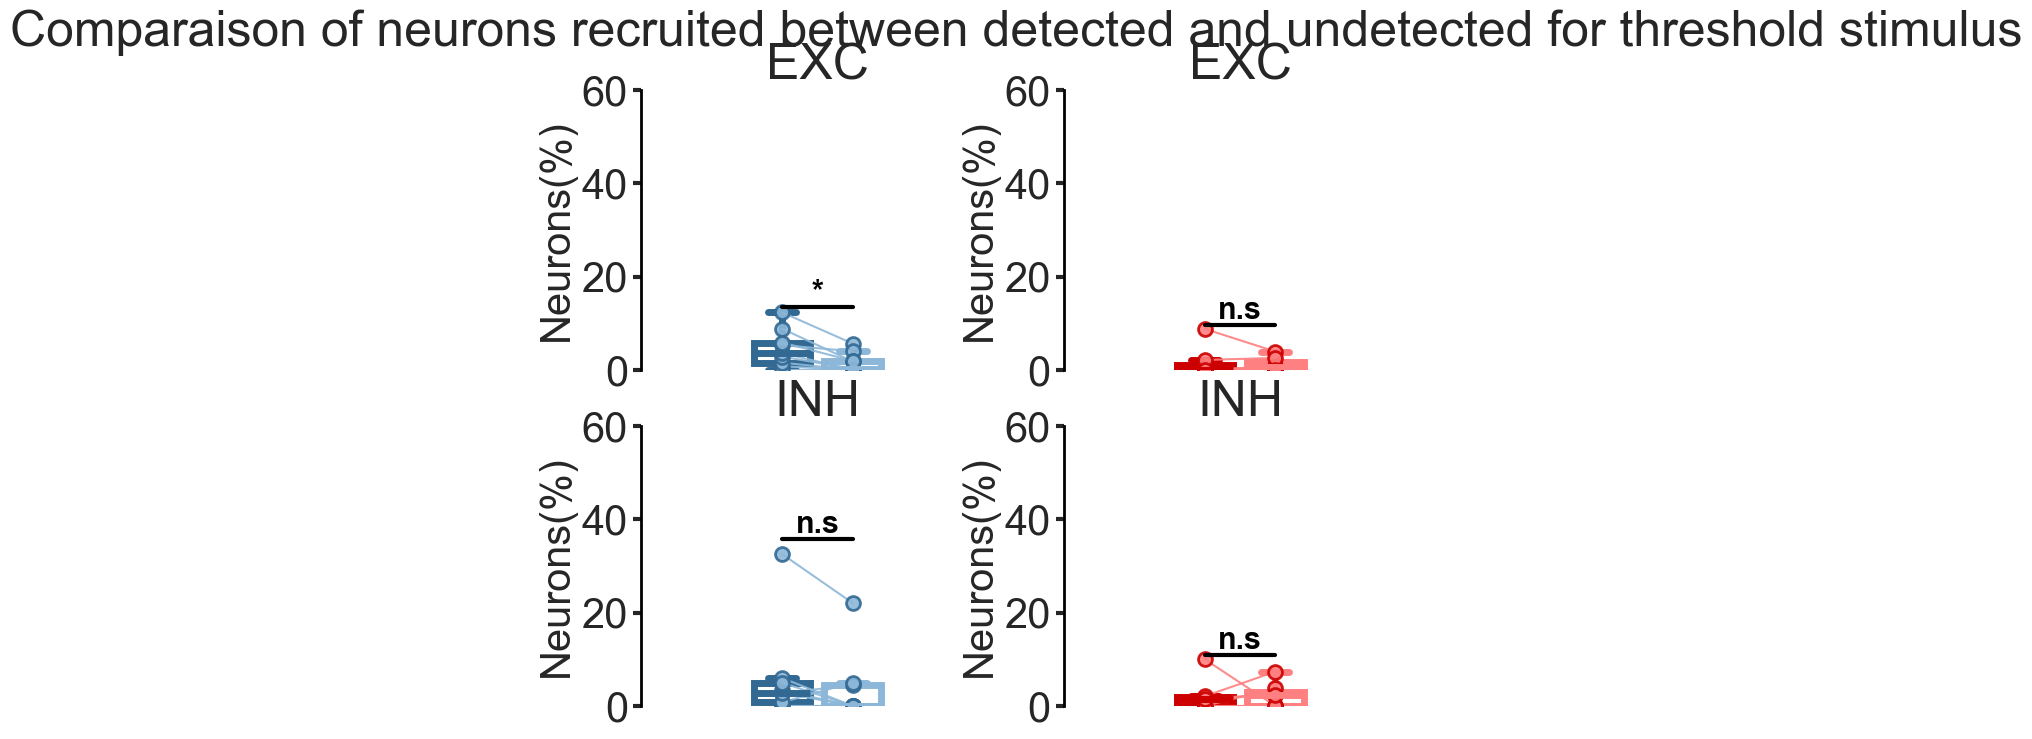

In [23]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=0, n_type=type, ko="KO-Hypo", stim_ampl="threshold")
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)", type,ylim=[0,50],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)", type,ylim=[0,50])
    fig.suptitle("Comparaison of neurons recruited between detected and undetected for threshold stimulus")

## Fraction of neurons activated(1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9012974689518968, pvalue=0.25961360616511475)
ShapiroResult(statistic=0.8579963536742773, pvalue=0.09118484607524704)
TtestResult(statistic=1.962442542626068, pvalue=0.0853351940540065, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6013049141618023, pvalue=0.0002820061798576861)
ShapiroResult(statistic=0.6681406789456539, pvalue=0.001647677864366729)
WilcoxonResult(statistic=3.0, pvalue=0.4652088184521418)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7430729904125217, pvalue=0.00450561804886148)
ShapiroResult(statistic=0.6503203948624401, pvalue=0.00037230049879015994)
WilcoxonResult(statistic=16.0, pvalue=0.779434528427275)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7892127514235512, pvalue=0.031987317013953874)
ShapiroResult(statistic=0.8664819405256665, pvalue=0.1728753077663281)
WilcoxonResult(statistic=9.0, pvalue=0.7531523647659145)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


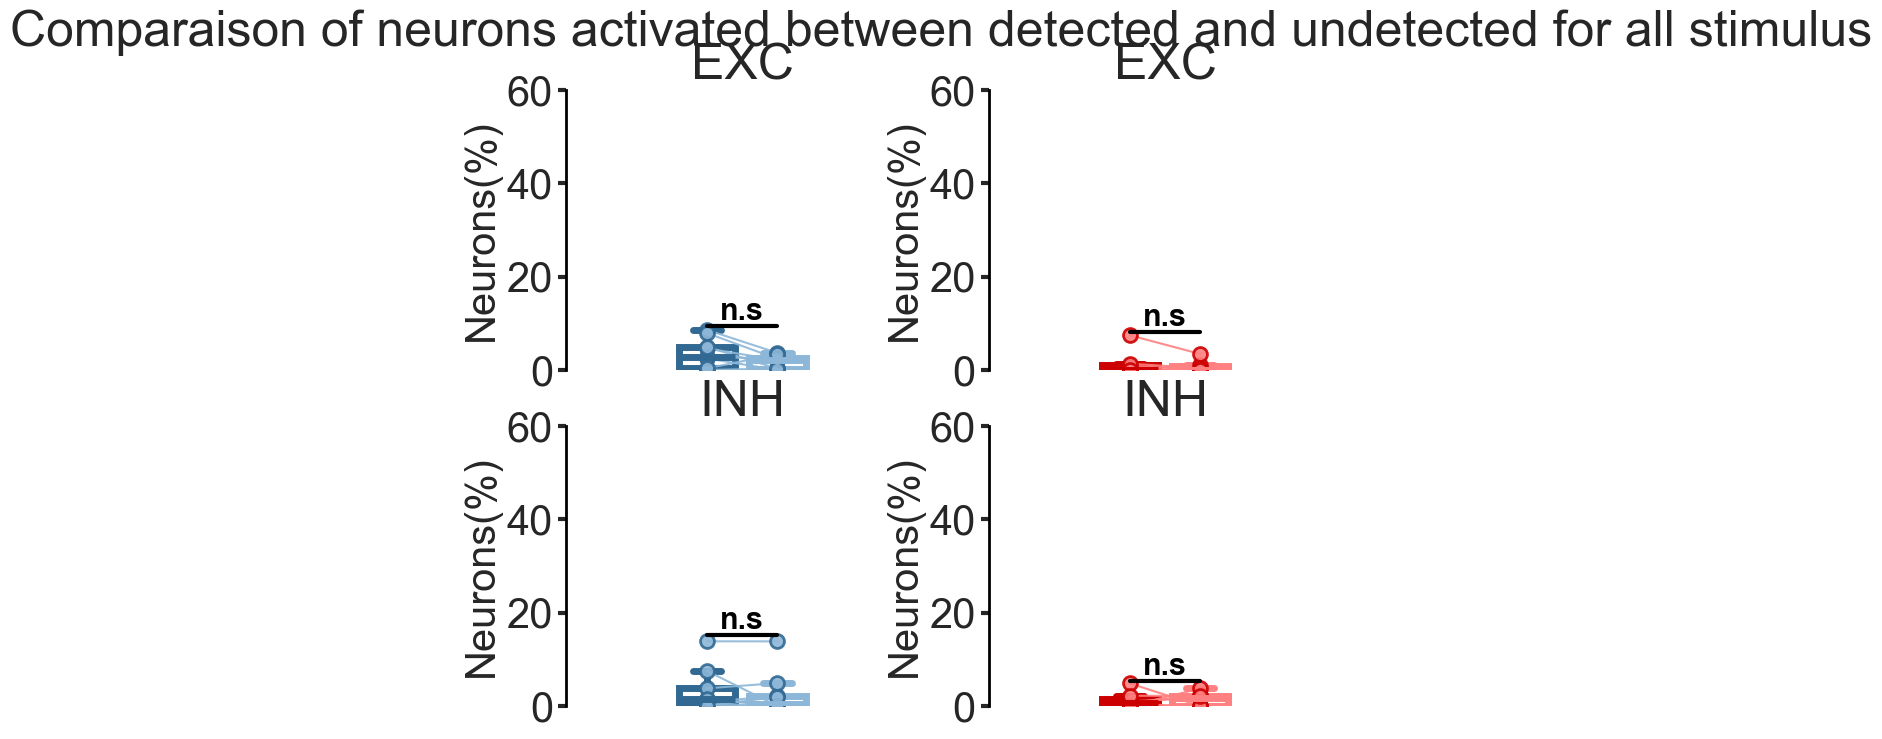

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type=type, ko="KO-Hypo", stim_ampl="all")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 50],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 50])
    fig.suptitle("Comparaison of neurons activated between detected and undetected for all stimulus")

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9222707322019759, pvalue=0.41137093630729243)
ShapiroResult(statistic=0.8036178644680267, pvalue=0.022457124672917463)
WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5732347571745722, pvalue=0.0001310134537644916)
ShapiroResult(statistic=0.8080416566700892, pvalue=0.0491527120245109)
WilcoxonResult(statistic=4.0, pvalue=0.7150006546880893)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5702862147906649, pvalue=4.284994253860477e-05)
ShapiroResult(statistic=0.6180990264840466, pvalue=0.00015601404312976937)
WilcoxonResult(statistic=10.0, pvalue=0.49896229860376107)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6215079551466645, pvalue=0.00048516110009413053)
ShapiroResult(statistic=0.8695285046469364, pvalue=0.18387225650378625)
WilcoxonResult(statistic=5.0, pvalue=0.5001842570707944)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


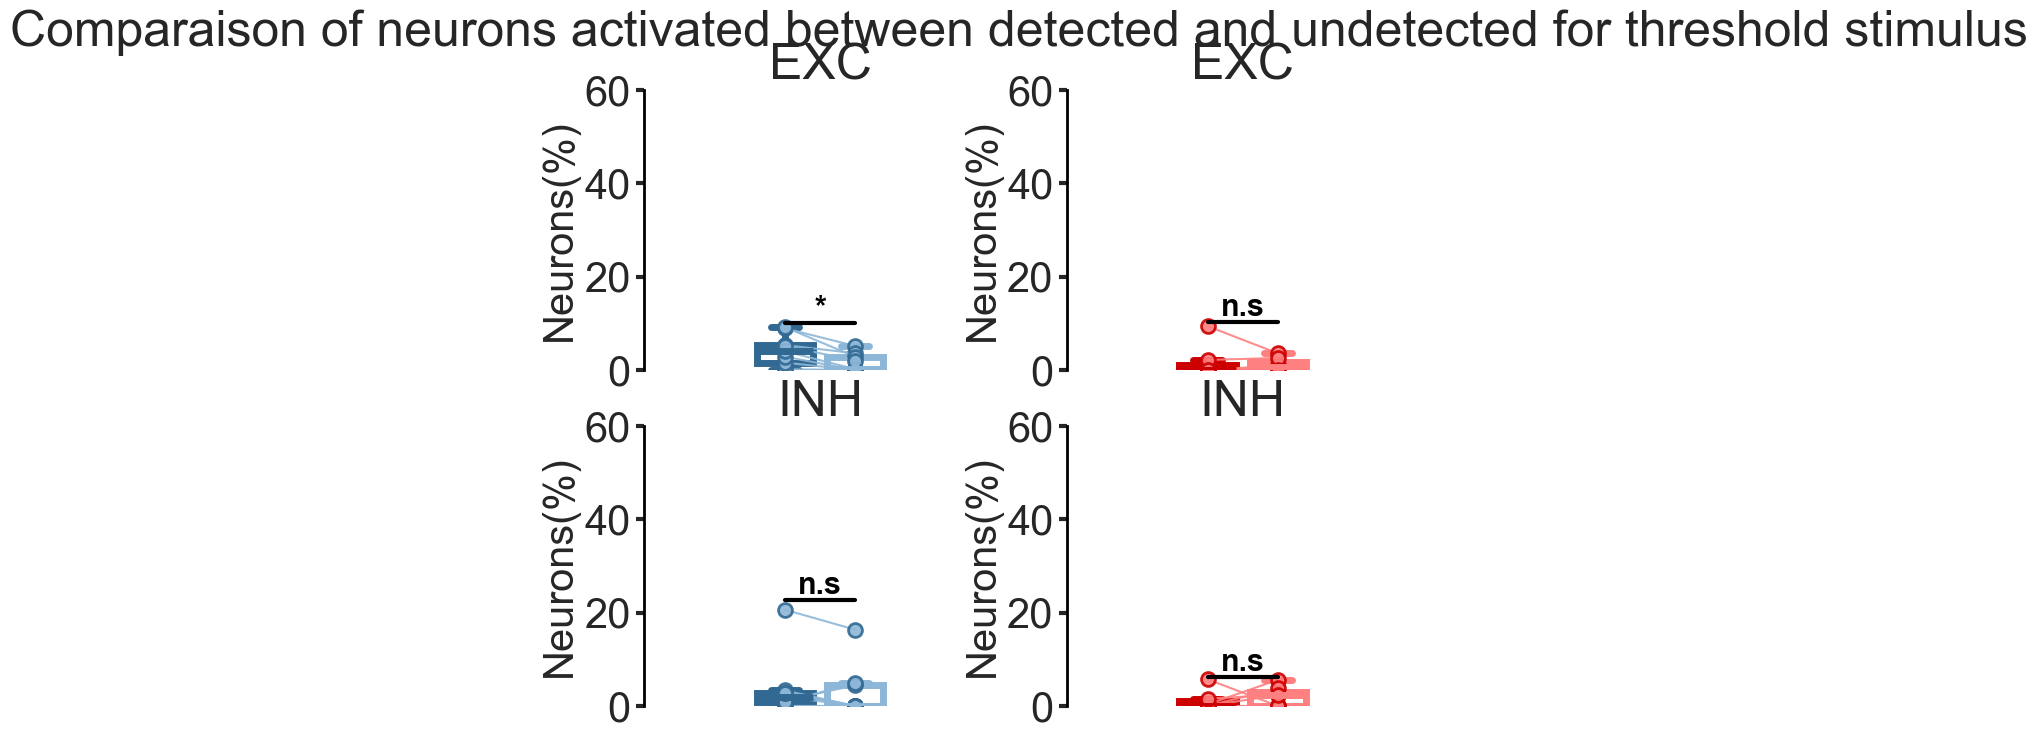

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type=type, ko="KO-Hypo", stim_ampl="threshold")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 50],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 50])
    fig.suptitle("Comparaison of neurons activated between detected and undetected for threshold stimulus")

## Fraction of neurons inhibited (-1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5099572247407815, pvalue=8.373106612716098e-06)
ShapiroResult(statistic=0.8301099269928381, pvalue=0.04478173354653412)
WilcoxonResult(statistic=6.0, pvalue=0.17629637444051116)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7271825951321498, pvalue=0.007285342618685573)
ShapiroResult(statistic=0.892421710486184, pvalue=0.28753554654850405)
WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.4513623519346477, pvalue=1.7105988109789248e-06)
ShapiroResult(statistic=0.3898412978727055, pvalue=3.2174928627621727e-07)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8766371680435252, pvalue=0.21193487224459617)
ShapiroResult(statistic=0.7053028305018543, pvalue=0.004234679579045571)
WilcoxonResult(statistic=1.0, pvalue=0.14412703481601533)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


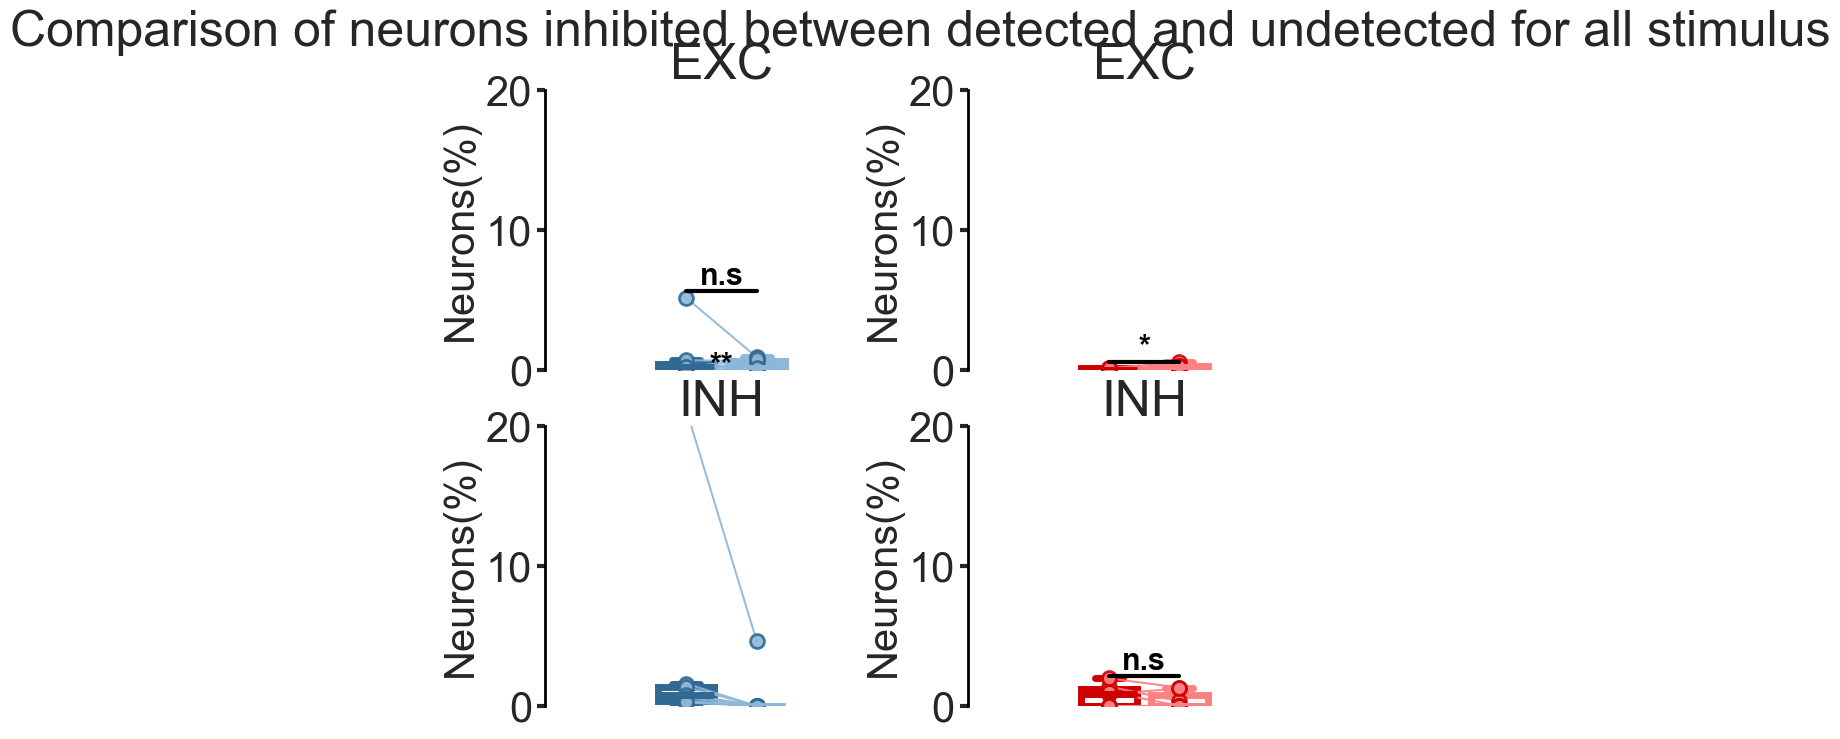

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type=type, ko="KO-Hypo", stim_ampl="all")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 20],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 20])
    fig.suptitle("Comparison of neurons inhibited between detected and undetected for all stimulus")

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5499725327819309, pvalue=2.4734917211246008e-05)
ShapiroResult(statistic=0.7929534929479919, pvalue=0.016962639670897842)
WilcoxonResult(statistic=10.0, pvalue=0.49896229860376107)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7520424825562111, pvalue=0.013326108713196871)
ShapiroResult(statistic=0.7226431270841036, pvalue=0.006515153622972194)
WilcoxonResult(statistic=7.0, pvalue=0.892738400944348)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6503292126529452, pvalue=0.00037238906608611107)
ShapiroResult(statistic=0.3898412978727055, pvalue=3.2174928627621727e-07)
WilcoxonResult(statistic=0.0, pvalue=0.06788915486182899)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7507202083731525, pvalue=0.012909428510024561)
ShapiroResult(statistic=0.6135421134273908, pvalue=0.0003920858181991304)
WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


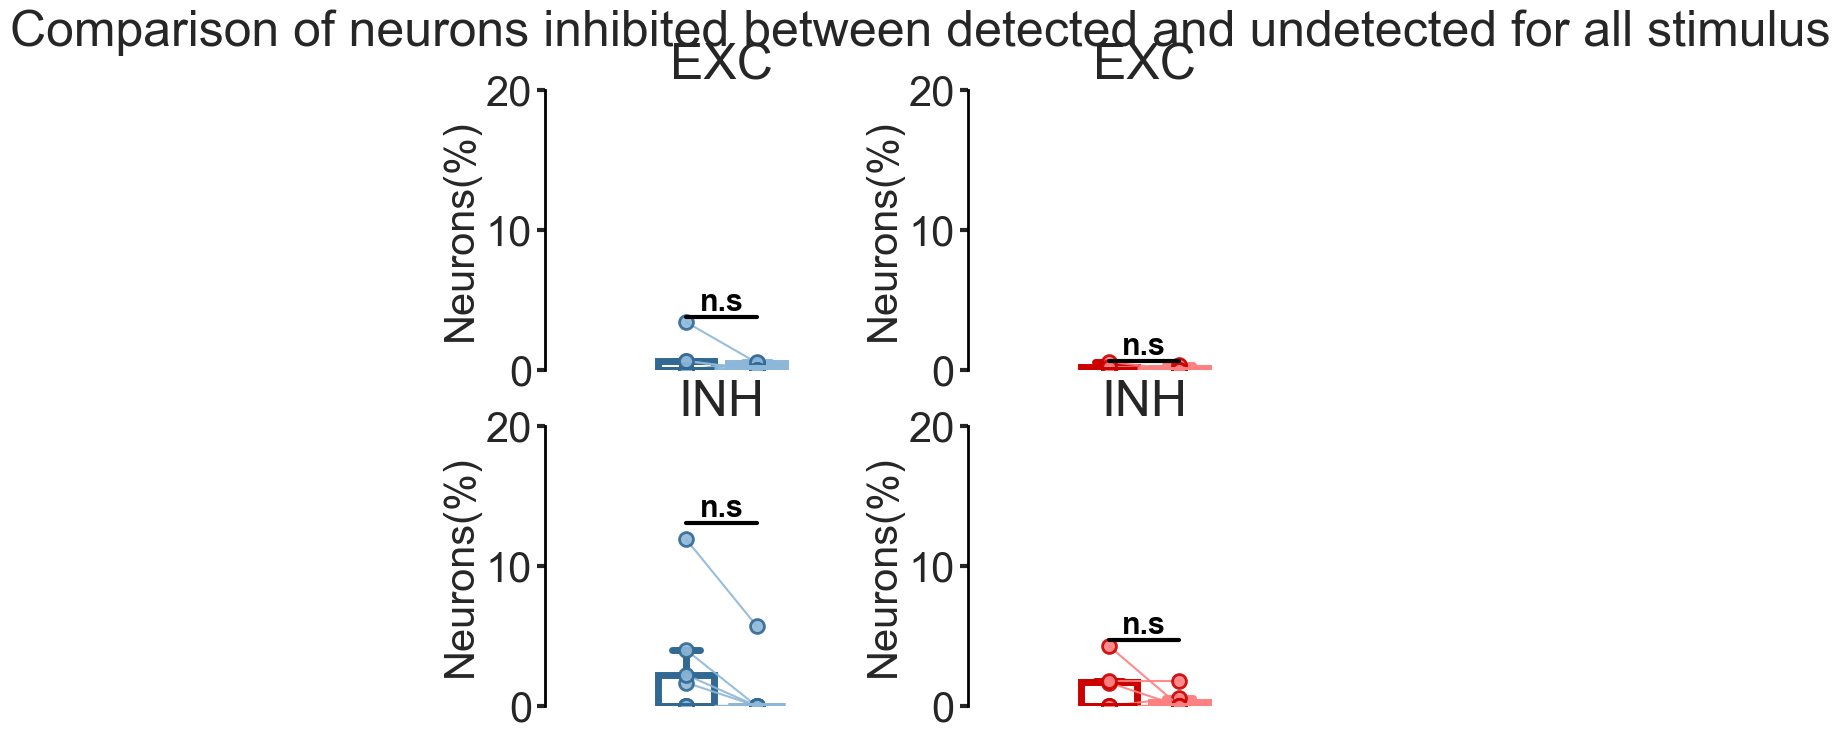

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type=type, ko="KO-Hypo", stim_ampl="threshold")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 20],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 20])
    fig.suptitle("Comparison of neurons inhibited between detected and undetected for all stimulus")

# Responsivity per amplitude line graphs 22/03/2024  

## Graph of activated neurons from amplitude

4456
4745
4939
5886
5896
5879
5889
5873
6606
wt [[ 6.05693519 10.23622047 11.26589945 12.69106068 11.3735783  12.90463692]
 [ 4.72727273  5.30909091  3.46666667  5.14285714  4.93333333  5.33333333]
 [ 3.87038704  4.95049505  3.08030803  2.77227723  4.37293729  1.98019802]
 [ 3.3492823   6.93779904  8.55263158  9.90712074  9.71659919  6.7251462 ]
 [ 4.55465587  4.21052632  6.79824561  6.28654971  7.01754386  6.39097744]
 [ 5.73426573  5.27272727  6.54545455  5.95041322  4.90909091  8.83116883]
 [ 6.30797774  4.42176871  7.14285714  8.16326531  7.79220779  9.62099125]
 [ 4.67032967  2.1978022   9.41915228  8.05860806  3.2967033   6.22710623]
 [ 5.22875817  7.84313725  9.80392157  7.84313725  3.38680927  2.45098039]]
--- amp 2 ---
ShapiroResult(statistic=0.9640604468680065, pvalue=0.8397131552394821)
ShapiroResult(statistic=0.8223502533391076, pvalue=0.06764551954042008)
LeveneResult(statistic=2.7827511831898017, pvalue=0.11748657204729887)
Equal variances :TtestResult(statistic=-2.729511

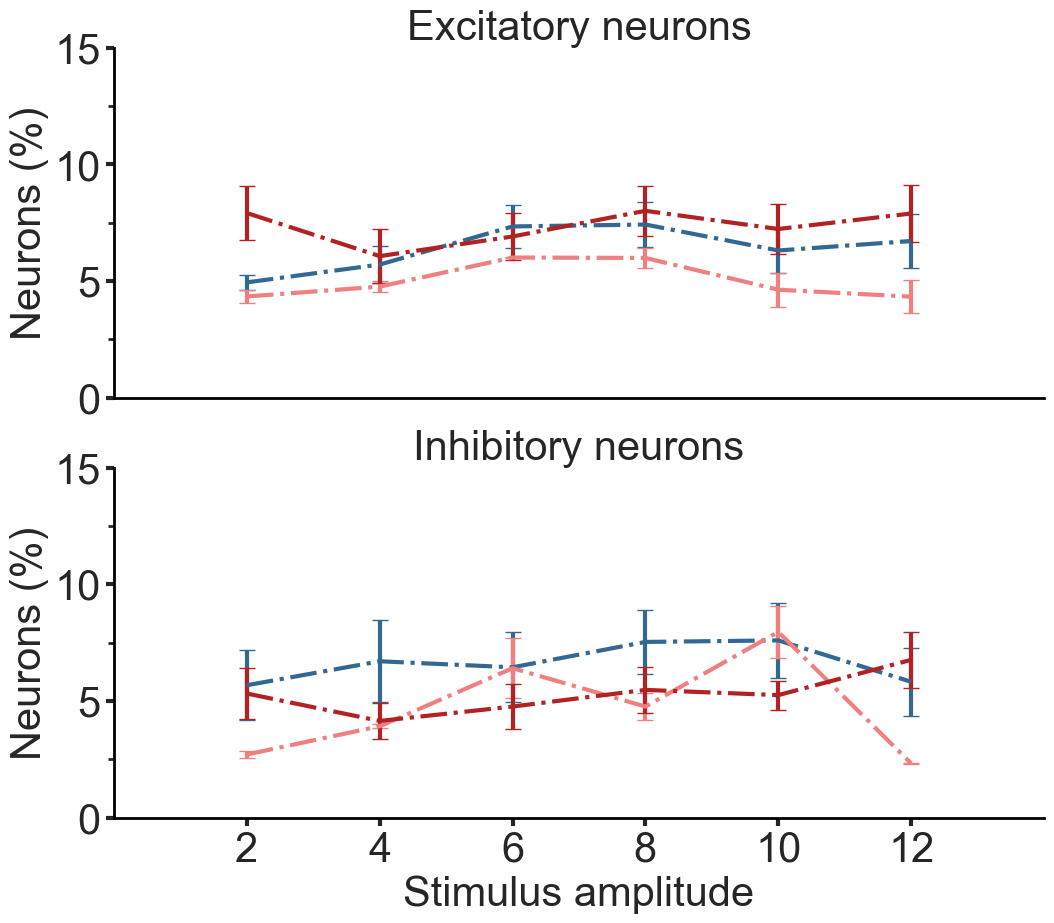

In [18]:
figs, axs = plt.subplots(2,1,figsize=(12,10))
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}

amps = [2,4,6,8,10,12]
for i, n_type in enumerate(["EXC","INH"]):
    wt, ko, ko_hypo = [], [], []
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        resp_p=[]
        # The no-go trials are used to normalized
        trials_no_go = resp_mat[:, rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)]
        # The total number of neurons is computed
        total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
        
        trials_no_go[trials_no_go != 1] = 0
        recruited_no_go = np.mean(np.count_nonzero(trials_no_go,axis=0))
        # For each amplitude, the number of activated neurons is computed
        for amp in amps:
            trials_detected = resp_mat[:, rec.stim_ampl==amp]
            trials_detected[trials_detected != 1] = 0
            recruited_det = np.mean(np.count_nonzero(trials_detected, axis=0))
            # recruited_det -= recruited_no_go
            # recruited_det = 0 if recruited_det < 0 else recruited_det
            
            perc_n_det = (recruited_det/total_n)*100
            if np.isfinite(perc_n_det):
                resp_p.append(perc_n_det)
            else: 
                print(perc_n_det)
                resp_p.append(0)
        if rec.genotype == "WT":
            wt.append(resp_p)
            print(rec.filename)
        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(resp_p)
        elif rec.genotype =="KO":
            ko.append(resp_p)
        
    wt_array = np.array(wt)
    koh_array = np.array(ko_hypo)
    sign_list = []
    print("wt", wt_array)
    
    for index, amplitude in enumerate(amps):
        pval = ppt.stat_boxplot(wt_array[:, index], koh_array[:, index], f"amp {amplitude}", paired=False)
        sign_list.append(ppt.symbol_pval(pval))
        
    print(sign_list)
    
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw =3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(ko,axis=0),capsize=6,markersize=15, lw =3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(ko_hypo,axis=0),capsize=6,markersize=15, lw =3)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[i].grid(False)
    axs[i].set_facecolor("white")
    axs[i].spines["left"].set_color("black")
    axs[i].spines["bottom"].set_color("black")
    axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True, bottom=True)
    axs[i].tick_params(axis='both', which='minor', length=4, width=2, left=True, bottom=True)
    axs[i].set_ylabel("Neurons (%)", fontsize = 30)
    axs[i].set_xlabel("Stimulus amplitude", fontsize = 30)
    axs[i].set_xlim([0,14])
    axs[i].set_ylim([0,15])
    axs[i].set_title(labels[n_type], fontsize =30)
    axs[i].tick_params(axis='both', labelsize=30)
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].spines[['right', 'top',]].set_visible(False)
    axs[0].get_xaxis().set_visible(False)

## Graph of amplitude response from each stimulus amplitude


C:\Users\cvandromme\AppData\Local\Temp\ipykernel_6272\3387693781.py:15: RuntimeWarning: Mean of empty slice
  output = np.nanmean(np.nanmean(trials, axis=1))


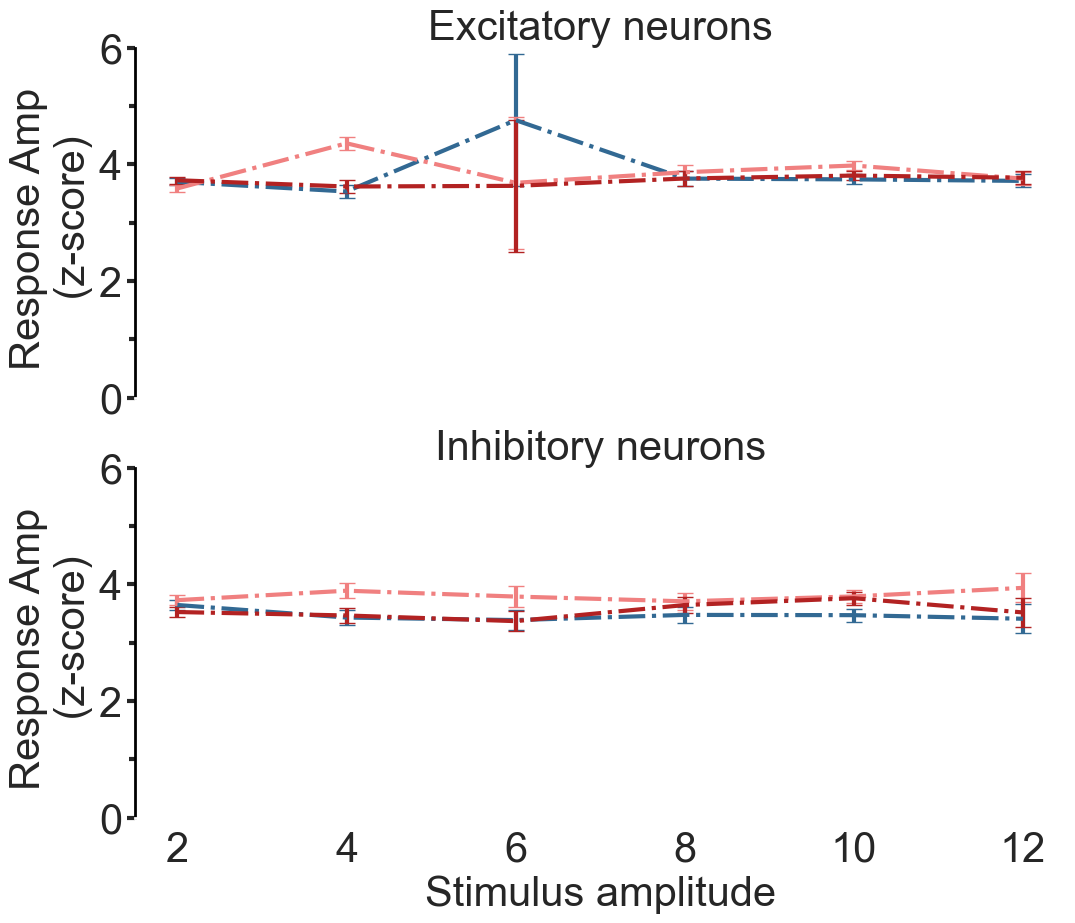

In [19]:
figs, axs = plt.subplots(2,1,figsize=(12,10))

amps=[2,4,6,8,10,12]
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        rec.peak_delay_amp()
        mat = np.array(rec.matrices[type]["Peak_amplitude"])
        mat[mat<0]=np.nan

        _p=[]
        for amp in amps:
            trials = mat[:,rec.stim_ampl==amp]
            output = np.nanmean(np.nanmean(trials, axis=1))
            if np.isnan(output ):
                output = 0
            _p.append( output)
            
        if rec.genotype == "WT":
            wt.append(_p)

        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(_p)
        elif rec.genotype =="KO":
            ko.append(_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].grid(False)
    axs[i].set_facecolor("white")
    axs[i].spines["left"].set_color("black")
    axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True)
    axs[i].tick_params(axis='both', which='minor', length=4, width=3, left=True)
    axs[i].set_ylabel("Response Amp \n (z-score)", fontsize =30)
    axs[i].set_xlabel("Stimulus amplitude", fontsize =30)
    axs[i].set_title(labels[type], fontsize =30)
    axs[i].tick_params(axis='both', labelsize=30)
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].set_ylim([0,6])
    axs[i].spines[['right', 'top',]].set_visible(False)
axs[0].get_xaxis().set_visible(False)

# Psychometric curves like graphs for fraction of resp neurons

Number of active neurons and behavior psychometric curves comparison animal by animals

Text(0.5, 0.98, 'Percentage of neurons recruited for all trials amplitude')

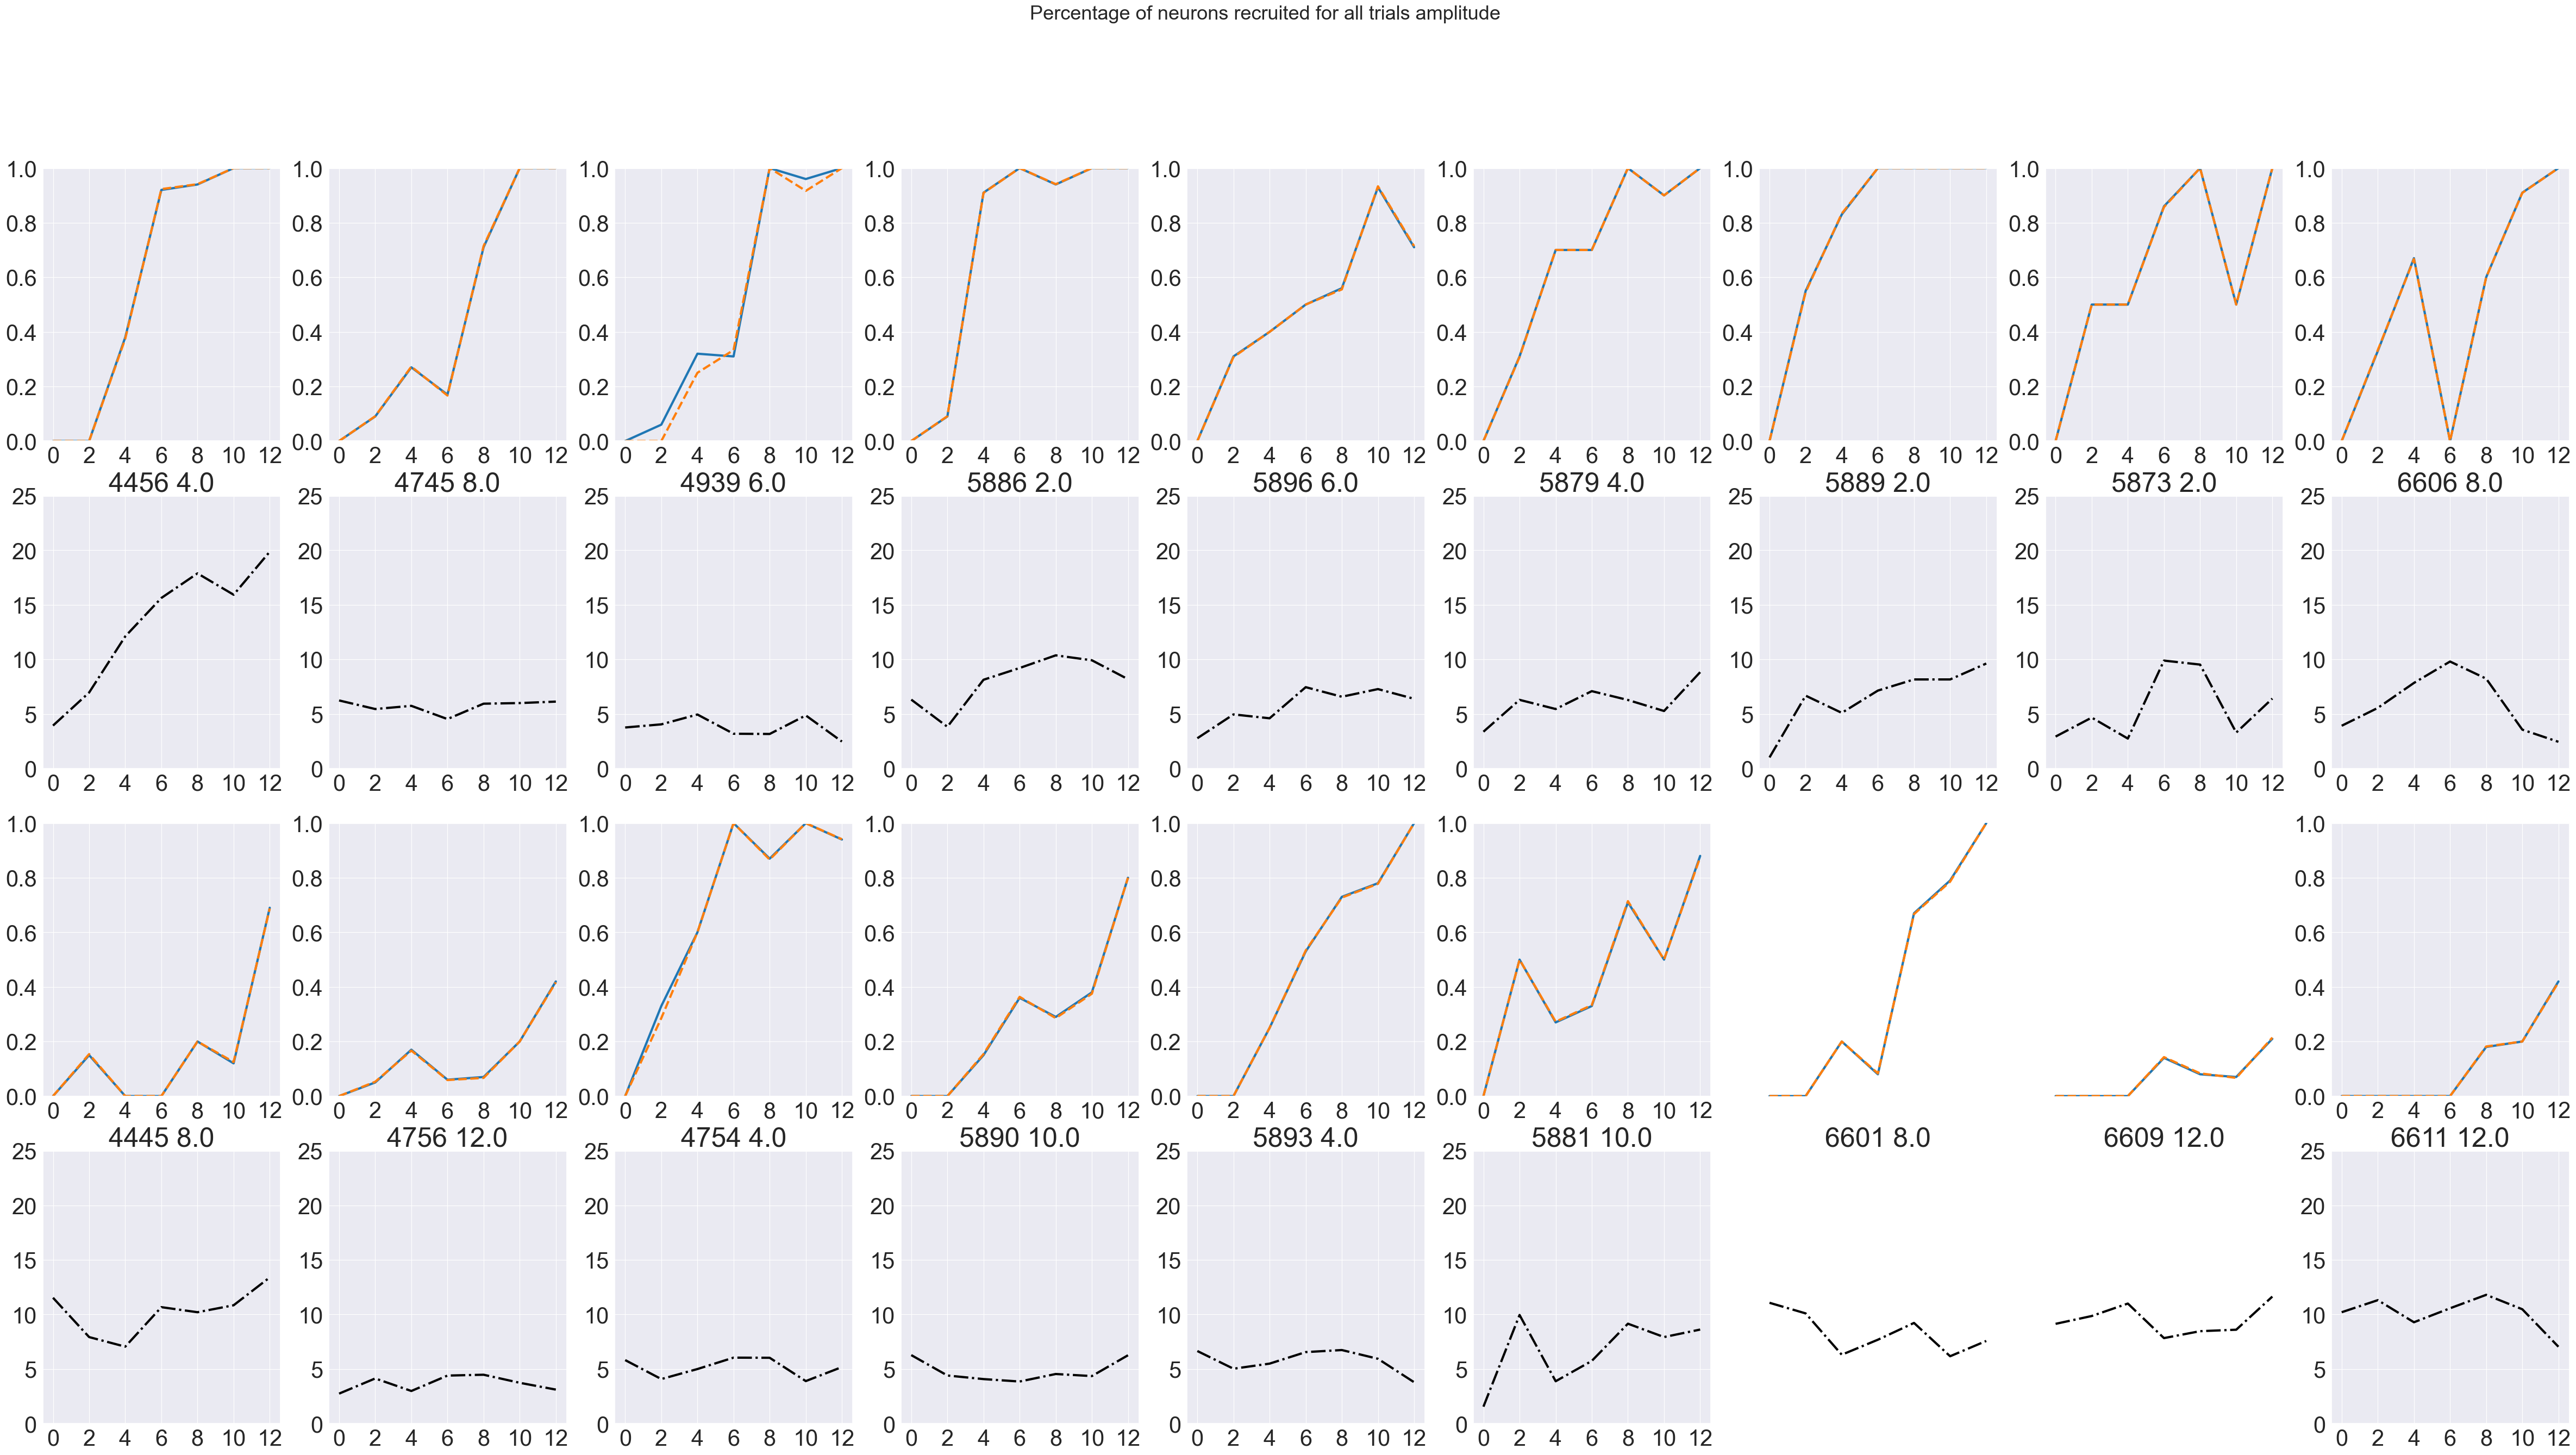

In [20]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=26)

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index 8 is out of bounds for axis 1 with size 8

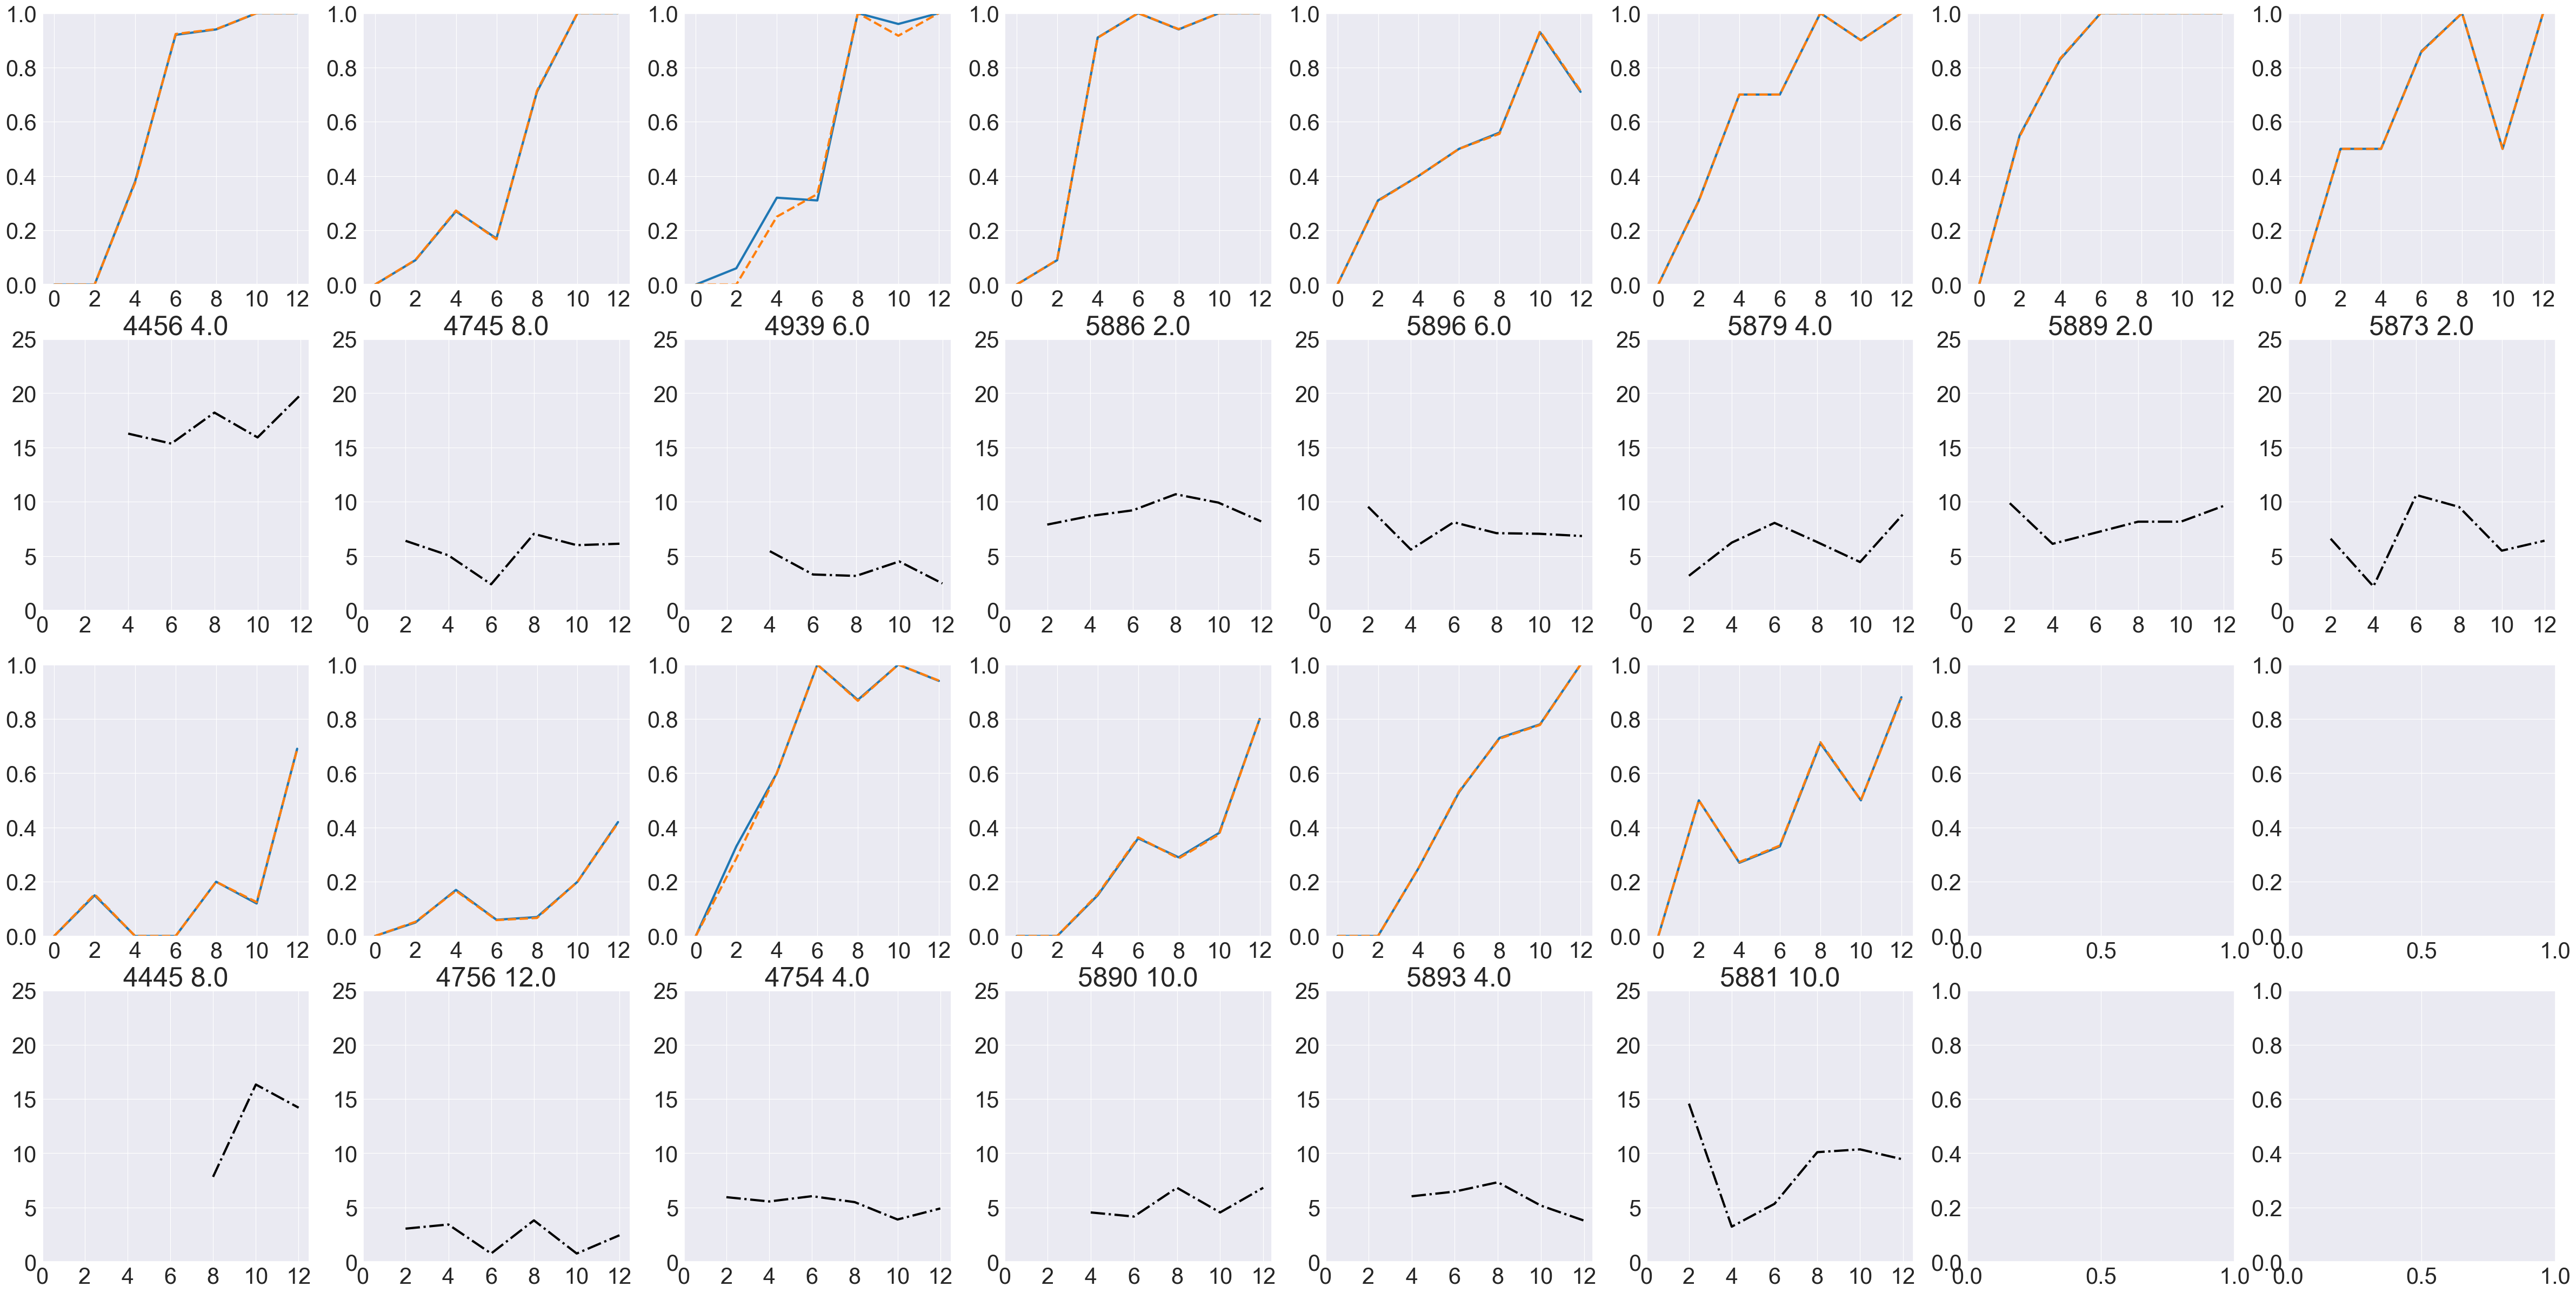

In [21]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 1] = 0
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    nb_trials= []
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
        nb_trials.append(len(rec.stim_ampl[rec.stim_ampl == amp]))
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    # ax.bar([0, 2, 4, 6, 8, 10, 12], nb_trials)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=26)

percentage of neurons recruited for UNDETECTED TRIALS

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])

            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()


fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=26)

# Signal-to-Noise ratio (nb of neurons due to stimulus vs nb of neurons bsl) 


In [ ]:
def SNR( pattern, n_type, ko, stim_ampl="all"):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_detected = resp_mat[:,ampl_det_filt]
        trials_undetected = resp_mat[:,ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0

        recruited_det = np.count_nonzero(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if  n_type== "INH":
            total_n = len(rec.zscore_inh)
        n_baseline = np.mean(np.count_nonzero(resp_mat[:,rec.stim_ampl==0],axis=0))
        snr_det = (((np.mean(recruited_det)-n_baseline)/total_n)*100)
        #undetected
        recruited_undet = np.count_nonzero(trials_undetected,axis=0)
        snr_undet =(((np.mean(recruited_undet)-n_baseline)/total_n)*100)
        if rec.genotype == "WT":
            wt_det.append(snr_det)
            wt_undet.append(snr_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
    return wt_det, ko_det, wt_undet, ko_undet

In [ ]:
    wt_det, ko_det, wt_undet, ko_undet = SNR(pattern=0, n_type="EXC", ko="KO-hypo", stim_ampl="all")
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    ylim= [0,15]
    ppt.boxplot(axs[0, 0], wt_det,ko_det,"Neurons(%)",ylim=ylim)
    axs[0, 0].set_title("SNR EXC Detected", fontsize=10)
    ppt.boxplot(axs[0, 1], wt_undet,ko_undet,"Neurons(%)",ylim=ylim)
    axs[0, 1].set_title("SNR EXC Undetected", fontsize=10)
    wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=0, n_type="INH", ko="ko-hypo", stim_ampl="all")
    ppt.boxplot(axs[1, 0], wt_det1,ko_det1,"Neurons(%)",ylim=ylim)
    axs[1, 0].set_title("SNR INH Detected", fontsize=10)
    ppt.boxplot(axs[1, 1], wt_undet1,ko_undet1,"Neurons(%)",ylim=ylim)
    axs[1, 1].set_title("SNR INH Undetected", fontsize=10)